# Data Exploration and Cleaning

__Project Goal__

Compare recipes from two popular recipe websites, Spoonacular and Food.com, and identify "healthy" recipes using two market-implemented measures: `Nutri-Scores` and `Weight Watchers (WW) Smart Points`.

The project will investigate recipe popularity, meal types, and cuisines.

__Scope__
* Nutritional values of interest: `calories`, `saturated fat`, `sugar`, and `protein`.
* Meal types: `breakfast`, `lunch`, and `dinner`.
* Cuisines

__Research Questions__
1. Are more popular / higher-rated recipes healthier? What is the health rating of the highest-rated recipes?
2. What meal type (i.e., breakfast, lunch, or dinner) have the healthiest / unhealthiest (percentage) recipes? What is the most popular ingredient for each meal?
3. Which cuisine has the healthiest recipes?

# Setup
This section contains the library imports and functions used throughout the project.

In [1]:
# Import libraries
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import scipy.stats as stats
import hvplot.pandas

# Import API keys
from alyssa_config import spoonacular_key, rapidapi_key, geoapify_key
# from lakna_config import spoonacular_key

# Import functions notebook
%run functions.ipynb

# Data Exploration - Food.com

__Goal__
* Identify dataset format and required attributes.
* Extract required attributes.

__Datasets__
1. `RAW_recipes.csv` (~300 MB)
2. `RAW_interactions.csv` (~350 MB)

In [2]:
# Import the FOOD.COM datasets as DataFrames.
food_df = pd.read_csv('Resources/RAW_recipes.csv')
interactions_df = pd.read_csv('Resources/RAW_interactions.csv')

## Data Format and Attributes

In [3]:
# Display the DataFrame
food_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [4]:
# Display the DataFrame
interactions_df.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [5]:
# Get the DataFrame dimensions
interactions_shape = interactions_df.shape
food_shape = food_df.shape

# Print findings
hash = f'{8*"#"}'
print(f'{hash} Shape {hash}')
print(f"food_df: {food_shape}")
print(f"interactions_df: {interactions_shape}")

# Get the columns
print(f'\n{hash} Columns {hash}')
print(f'food_df: {food_df.columns}')
print(f'interactions_df: {interactions_df.columns}')

# Get the datatypes
print(f'\n{hash} Data Types {hash}')
print(f'food_df: {food_df.dtypes}')
print(f'\ninteractions_df: {interactions_df.dtypes}')

######## Shape ########
food_df: (231637, 12)
interactions_df: (1132367, 5)

######## Columns ########
food_df: Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'],
      dtype='object')
interactions_df: Index(['user_id', 'recipe_id', 'date', 'rating', 'review'], dtype='object')

######## Data Types ########
food_df: name              object
id                 int64
minutes            int64
contributor_id     int64
submitted         object
tags              object
nutrition         object
n_steps            int64
steps             object
description       object
ingredients       object
n_ingredients      int64
dtype: object

interactions_df: user_id       int64
recipe_id     int64
date         object
rating        int64
review       object
dtype: object


## Extract Ratings from interactions_df

In [6]:
# Check how many recipes have ratings
unique_ratings = len(interactions_df['recipe_id'].unique())

# Check how many recipes have a '0' rating
zero_rating_df = interactions_df.loc[interactions_df['rating'] == 0]['recipe_id'].unique()

# Drop the rows with a '0' rating
nonzero_df = interactions_df.loc[interactions_df['rating'] != 0]
nonzero_shape = nonzero_df.shape

# Print findings
print(f'Recipes with ratings: {unique_ratings} out of {food_shape[0]}')
print(f'Recipes with a "0" rating: {zero_rating_df.shape[0]}')
print(f'Updated shape: {nonzero_shape}')

Recipes with ratings: 231637 out of 231637
Recipes with a "0" rating: 35114
Updated shape: (1071520, 5)


In [7]:
# Create a DataFrame with the average ratings per recipe ID
food_ratings = nonzero_df.groupby('recipe_id')['rating'].mean().reset_index()

# Display the DataFrame
food_ratings.head()

,recipe_id,rating
0,38,4.250000
1,39,3.000000
2,40,4.333333
3,41,4.500000
4,43,1.000000


In [8]:
# Rename the recipe ID column for merging with food_df
food_ratings = food_ratings.rename(columns={'recipe_id': 'id'})

# Merge the datasets and display updated DataFrame
merged_food = pd.merge(food_df, food_ratings, on='id')

# Confirm the row dimensions, to ensure correct merge
merged_shape = merged_food.shape
print(f'food_ratings rows: {food_ratings.shape[0]}')
print(f'merged_food rows: {merged_shape[0]}')

# Display the DataFrame
merged_food.head()

food_ratings rows: 226590
merged_food rows: 226590


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,5.000000
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4.666667
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,4.000000
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,4.500000
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,5.000000


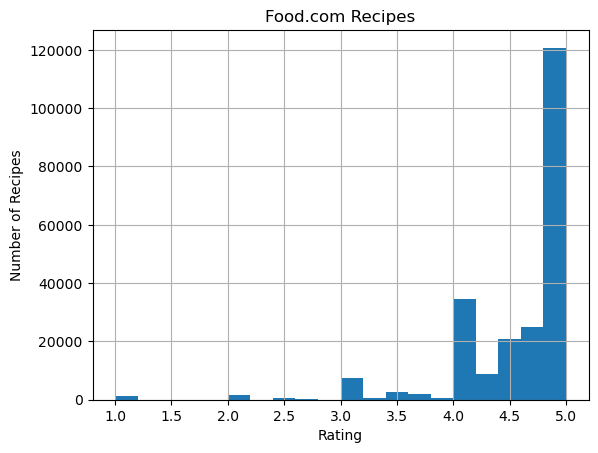

In [9]:
# Create a histogram of the ratings
merged_food['rating'].hist(bins=20)
plt.title("Food.com Recipes")
plt.xlabel("Rating")
plt.ylabel("Number of Recipes")
plt.show()

## Check for duplicate recipe IDs

In [10]:
# Determine whether there are duplicate recipes by ID
dup_id = len(merged_food['id'].unique())
print(f'Unique recipe IDs: {dup_id} of {merged_shape[0]}')

# Determine whether there are duplicate recipes by name
dup_name = len(merged_food['name'].unique())
print(f'Unique recipe names: {dup_name} of {merged_shape[0]}')

# Get the duplicate names - remove to simplify the dataset
duplicate_names = merged_food.loc[merged_food.duplicated(['name'])]
dupname_shape = duplicate_names.shape
print(f'Number of duplicate rows to remove: {dupname_shape[0]}\n')

# Create a new DataFrame without the duplicates
updated_food = merged_food.loc[~merged_food.duplicated(['name'])].copy()
updated_shape = updated_food.shape
print(f'updated_food: {updated_shape}')

# Display the DataFrame
updated_food.head()

Unique recipe IDs: 226590 of 226590
Unique recipe names: 225190 of 226590
Number of duplicate rows to remove: 1400

updated_food: (225190, 13)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,5.000000
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4.666667
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,4.000000
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,4.500000
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,5.000000


## Parse the `tags` column
* Extract meal types.
* Extract cuisines.

In [11]:
# Identify how to isolate each tag
tag_string = updated_food['tags'][0].strip("[]")
tag_string = tag_string.split(', ')
tag_string[0].strip("'")

# Get a list of unique tags
unique_tags = []
for string in updated_food['tags']:
    # Strip and split the string to a list
    tag_list = string.strip("[]").split(', ')
    for word_idx in range(len(tag_list)):
        # Get the tag
        tag = tag_list[word_idx].strip("'")
        if tag not in unique_tags:
            unique_tags.append(tag)

# Display the tags alphabetically
print(f"Number of unique tags: {len(unique_tags)}")
sorted(unique_tags)

Number of unique tags: 547


['',
 '1-day-or-more',
 '15-minutes-or-less',
 '3-steps-or-less',
 '30-minutes-or-less',
 '4-hours-or-less',
 '5-ingredients-or-less',
 '60-minutes-or-less',
 'Throw the ultimate fiesta with this sopaipillas recipe from Food.com.',
 'a1-sauce',
 'african',
 'american',
 'amish-mennonite',
 'angolan',
 'appetizers',
 'apples',
 'april-fools-day',
 'argentine',
 'artichoke',
 'asian',
 'asparagus',
 'australian',
 'austrian',
 'avocado',
 'bacon',
 'baja',
 'baked-beans',
 'baking',
 'bananas',
 'bar-cookies',
 'barbecue',
 'bass',
 'bean-soup',
 'beans',
 'beans-side-dishes',
 'bear',
 'beef',
 'beef-barley-soup',
 'beef-kidney',
 'beef-liver',
 'beef-organ-meats',
 'beef-ribs',
 'beef-sauces',
 'beef-sausage',
 'beginner-cook',
 'beijing',
 'belgian',
 'berries',
 'beverages',
 'birthday',
 'biscotti',
 'bisques-cream-soups',
 'black-bean-soup',
 'black-beans',
 'blueberries',
 'bok-choys',
 'brazilian',
 'bread-machine',
 'bread-pudding',
 'breads',
 'breakfast',
 'breakfast-casserole

### Extract meal types
* Meal types of interest: `breakfast`, `lunch`, `dinner`

In [12]:
# Check the tags for meal types
meal_types = ["breakfast", "lunch", "dinner"]
match_meals = tag_check(meal_types)

# Print the results
print(f'Tags: {match_meals[0]}')
print(f'Not tags: {match_meals[1]}')
print(f'Alternative tags: {match_meals[2]}\n')

# Update the meal type list
meal_types[2] = "dinner-party"
print(f'Updated meal_types: {meal_types}')

Tags: ['breakfast', 'lunch']
Not tags: ['dinner']
Alternative tags: ['dinner-party']

Updated meal_types: ['breakfast', 'lunch', 'dinner-party']


In [13]:
# Get a count of each meal type
meal_dict = parse_tags(meal_types, 'tags', updated_food, 'id')

# Get the list of all recipes with one meal type
combined_meals = []
for key in meal_dict:
    print(f"{key}: {meal_dict[key]['count']}")
    if (key != 'multiple'):
        combined_meals.append(meal_dict[key]['id_list'])

# Flatten combined_meals
flat_meals = [index for meal_list in combined_meals for index in meal_list]

# Remove multiples to get a list of all recipes with one meal type
unique_meals = [meal for meal in flat_meals if meal not in meal_dict['multiple']['id_list']]

# Print results
print(f'\nTotal recipes with one meal type: {len(unique_meals)}')

breakfast: 13285
lunch: 23284
dinner-party: 36690
multiple: 6839

Total recipes with one meal type: 59707


In [14]:
# Reduce the dataset to contain recipes with only one meal type
reduced_food = updated_food.loc[updated_food['id'].isin(unique_meals)].copy()
reduced_shape = reduced_food.shape

# Create a new column with the meal type
for key in meal_dict:
    for id in meal_dict[key]['id_list']:
        if (key == "dinner-party"):
            key = "dinner"
        reduced_food.loc[reduced_food['id'] == id, 'meal_type'] = key

# Display the DataFrame
print(f'reduced_food: {reduced_shape}')
reduced_food.head()

reduced_food: (59707, 13)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating,meal_type
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,4.666667,breakfast
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,4.500000,dinner
6,aww marinated olives,25274,15,21730,2002-04-14,"['15-minutes-or-less', 'time-to-make', 'course...","[380.7, 53.0, 7.0, 24.0, 6.0, 24.0, 6.0]",4,['toast the fennel seeds and lightly crush the...,my italian mil was thoroughly impressed by my ...,"['fennel seeds', 'green olives', 'ripe olives'...",9,2.000000,dinner
8,bananas 4 ice cream pie,70971,180,102353,2003-09-10,"['weeknight', 'time-to-make', 'course', 'main-...","[4270.8, 254.0, 1306.0, 111.0, 127.0, 431.0, 2...",8,"['crumble cookies into a 9-inch pie plate , or...",NaN,"['chocolate sandwich style cookies', 'chocolat...",6,5.000000,lunch
9,beat this banana bread,75452,70,15892,2003-11-04,"['weeknight', 'time-to-make', 'course', 'main-...","[2669.3, 160.0, 976.0, 107.0, 62.0, 310.0, 138.0]",12,"['preheat oven to 350 degrees', 'butter two 9x...",from ann hodgman's,"['sugar', 'unsalted butter', 'bananas', 'eggs'...",9,4.400000,breakfast


### Extract cuisines
* Spoonacular supported cuisines ([Source](https://spoonacular.com/food-api/docs#Cuisines)):

`African, Asian, American, British, Cajun, Caribbean, Chinese, Eastern European, European, French, German, Greek, Indian, Irish, Italian, Japanese, Jewish, Korean, Latin American, Mediterranean, Mexican, Middle Eastern, Nordic, Southern, Spanish, Thai, Vietnamese`

__List input__:

African
Asian
American
British
Cajun
Caribbean
Chinese
Eastern European
European
French
German
Greek
Indian
Irish
Italian
Japanese
Jewish
Korean
Latin American
Mediterranean
Mexican
Middle Eastern
Nordic
Southern
Spanish
Thai
Vietnamese

In [15]:
# Convert Spoonacular supported cuisines to a list
# input_string = input("List to pass: ")
input_string = """African British Cajun Caribbean Chinese
    Eastern European French German Greek Indian Irish Italian
    Japanese Jewish Korean Latin American Mediterranean Mexican Middle Eastern
    Nordic Southern Spanish Thai Vietnamese"""

spoonacular_cuisines = input_string.split(' ')
spoonacular_cuisines = [word.lower() for word in spoonacular_cuisines]
spoonacular_cuisines # DOES NOT ACCOUNT FOR DOUBLE WORD.

# List comprehension to remove double words
double_words = ['eastern', 'european', 'latin', 'american', 'middle']
[spoonacular_cuisines.remove(word) for word in double_words]

# Return the two-word cuisines
spoonacular_cuisines += ['eastern european', 'latin american', 'middle eastern']
spoonacular_cuisines = sorted(spoonacular_cuisines)

In [16]:
# Check the tags for spoonacular cuisines
cuisine_match = tag_check(spoonacular_cuisines)[0]
print(f'Spoonacular Cuisines: {len(spoonacular_cuisines)}\n{spoonacular_cuisines}\n')
print(f'Matched cuisines: {len(cuisine_match)}\n{cuisine_match}')

Spoonacular Cuisines: 34
['', '', '', '', '', '', '', '', '', 'african', 'british', 'cajun', 'caribbean', 'chinese\n', 'eastern\n', 'eastern european', 'french', 'german', 'greek', 'indian', 'irish', 'italian\n', 'japanese', 'jewish', 'korean', 'latin american', 'mediterranean', 'mexican', 'middle eastern', 'nordic', 'southern', 'spanish', 'thai', 'vietnamese']

Matched cuisines: 23
['', '', '', '', '', '', '', '', '', 'african', 'cajun', 'caribbean', 'french', 'german', 'greek', 'indian', 'irish', 'japanese', 'korean', 'mexican', 'spanish', 'thai', 'vietnamese']


In [17]:
# Get a count of each cuisine
cuisine_dict = parse_tags(cuisine_match, 'tags', reduced_food, 'id')

# Get the list of all recipes with one meal type
combined_cuisines = []
for key in cuisine_dict:
    print(f"{key}: {cuisine_dict[key]['count']}")
    if (key != 'multiple'):
        combined_cuisines.append(cuisine_dict[key]['id_list'])

# Flatten combined_meals to get a list of unique recipes with one meal type
flat_cuisine = list(set([index for cuisine_list in combined_cuisines for index in cuisine_list]))

# Remove multiples to get a list of all recipes with one cuisine type
unique_cuisine = [cuisine for cuisine in flat_cuisine if cuisine not in cuisine_dict['multiple']['id_list']]
print(f'\nTotal recipes with one cuisine type: {len(unique_cuisine)} of {reduced_food.shape[0]}')

: 0
african: 710
cajun: 279
caribbean: 480
french: 1092
german: 383
greek: 787
indian: 743
irish: 215
japanese: 273
korean: 66
mexican: 1661
spanish: 369
thai: 285
vietnamese: 90
multiple: 148

Total recipes with one cuisine type: 7140 of 59707


In [18]:
# Reduce the dataset to contain recipes with only one cuisine
one_cuisine = reduced_food.loc[reduced_food['id'].isin(unique_cuisine)].copy()

# Create a new column with the cuisine
key_list = []
for key in cuisine_dict:
    if key != "multiple":
        key_list.append(key)
        for id in cuisine_dict[key]['id_list']:
            one_cuisine.loc[one_cuisine['id'] == id, 'cuisine'] = key

# Confirm unique cuisines
print(f"Unique cuisines:\n {one_cuisine['cuisine'].unique()}")

# Display the DataFrame
print(f'\none_cuisine: {one_cuisine.shape}')
one_cuisine.head()

Unique cuisines:
 ['indian' 'mexican' 'caribbean' 'greek' 'spanish' 'african' 'french'
 'irish' 'cajun' 'thai' 'german' 'vietnamese' 'japanese' 'korean']

one_cuisine: (7140, 15)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating,meal_type,cuisine
63,munch without guilt tomatoes,30300,10,6164,2002-06-04,"['15-minutes-or-less', 'time-to-make', 'course...","[3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",3,['put a slice of tomato on each biscuit / crac...,anytime munchies...another sweat free preparat...,"['tomatoes', 'crackers', 'mayonnaise', 'black ...",4,5.000000,dinner,indian
67,now and later vegetarian empanadas,38276,90,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,"['carrots', 'butter', 'onion', 'sliced mushroo...",22,4.200000,lunch,mexican
74,pour over anything mushroom gravy,35595,20,6164,2002-07-29,"['30-minutes-or-less', 'time-to-make', 'course...","[33.1, 0.0, 11.0, 0.0, 2.0, 0.0, 2.0]",6,"['in a small saucepan , saut onion and mushroo...",the name says it all...absolute must for all t...,"['onion', 'mushroom pieces', 'sodium-free vege...",8,3.000000,dinner,indian
97,tide me over indian chaat simple veggie salad,63793,2,12657,2003-06-05,"['15-minutes-or-less', 'time-to-make', 'course...","[73.1, 1.0, 15.0, 0.0, 5.0, 3.0, 4.0]",4,"['toss everything well in a serving bowl', 'gr...",this version of the famous indian chaat (prono...,"['cucumber', 'potato', 'chopped tomato', 'plai...",7,4.428571,lunch,indian
174,denauseating with ginger tea,30473,10,6164,2002-06-05,"['15-minutes-or-less', 'time-to-make', 'course...","[13.7, 0.0, 11.0, 0.0, 0.0, 0.0, 1.0]",5,['bring water to boil with crushed ginger in i...,actually an excellent drink to de-stress and f...,"['water', 'ginger', 'tea bag', 'honey', 'milk']",5,4.727273,breakfast,indian


## Convert `nutrition` column to nutritional values

__Column Contents__

calories (#), total fat (PDV), sugar (PDV), sodium (PDV) , protein (PDV), saturated fat, carbohydrates (PDV)

__Conversion Units__

* Total fat = 65g
* Sugar = 50g
* Sodium = 2400mg (2.4g)
* Protein = 50g
* Saturated fat = 20g
* Carbohydrates = 300g

__Sources__
* [Kaggle - Food.com Recipes and Interactions](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions/discussion/121778?select=RAW_recipes.csv&search=nutrition)
* [Absolute Amounts of Nutrients from Percent of Daily Values](http://krupp.wcc.hawaii.edu/biol100l/nutrition/dailyval.pdf)
* [Added Sugars on the New Nutrition Facts Label](https://www.fda.gov/food/new-nutrition-facts-label/added-sugars-new-nutrition-facts-label)

In [19]:
# Identify how to split the nutrition string and convert to float
test_string = one_cuisine['nutrition']

# Remove the square brackets
# test_string = test_string[1].strip("[]")
test_string = test_string[63].strip("[]")

# Split the string to a list
test_string = test_string.split(", ")

# Cast values to float
test_string = [float(value) for value in test_string]
test_string

[3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]

In [20]:
# Identify how to convert PDV to nutrient quantity
conversion_ref = [65, 50, 2.4, 50, 20, 300]

# Remove 'Calories' from the test string
test_pdv = test_string[1:]

# Convert from PDV to absolute values
abs_values = []
for ref in range(len(conversion_ref)):
    abs_values.append(test_pdv[ref] * conversion_ref[ref] / 100)
abs_values

[0.0, 0.5, 0.0, 0.0, 0.0, 0.0]

In [21]:
one_cuisine.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,rating,meal_type,cuisine
63,munch without guilt tomatoes,30300,10,6164,2002-06-04,"['15-minutes-or-less', 'time-to-make', 'course...","[3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",3,['put a slice of tomato on each biscuit / crac...,anytime munchies...another sweat free preparat...,"['tomatoes', 'crackers', 'mayonnaise', 'black ...",4,5.000000,dinner,indian
67,now and later vegetarian empanadas,38276,90,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,"['carrots', 'butter', 'onion', 'sliced mushroo...",22,4.200000,lunch,mexican
74,pour over anything mushroom gravy,35595,20,6164,2002-07-29,"['30-minutes-or-less', 'time-to-make', 'course...","[33.1, 0.0, 11.0, 0.0, 2.0, 0.0, 2.0]",6,"['in a small saucepan , saut onion and mushroo...",the name says it all...absolute must for all t...,"['onion', 'mushroom pieces', 'sodium-free vege...",8,3.000000,dinner,indian
97,tide me over indian chaat simple veggie salad,63793,2,12657,2003-06-05,"['15-minutes-or-less', 'time-to-make', 'course...","[73.1, 1.0, 15.0, 0.0, 5.0, 3.0, 4.0]",4,"['toss everything well in a serving bowl', 'gr...",this version of the famous indian chaat (prono...,"['cucumber', 'potato', 'chopped tomato', 'plai...",7,4.428571,lunch,indian
174,denauseating with ginger tea,30473,10,6164,2002-06-05,"['15-minutes-or-less', 'time-to-make', 'course...","[13.7, 0.0, 11.0, 0.0, 0.0, 0.0, 1.0]",5,['bring water to boil with crushed ginger in i...,actually an excellent drink to de-stress and f...,"['water', 'ginger', 'tea bag', 'honey', 'milk']",5,4.727273,breakfast,indian


In [22]:
# Parse each value in the `nutrition` column
for df_idx, row in one_cuisine.iterrows():
    # Strip and split the string to a list
    values_list = row['nutrition'].strip("[]").split(", ")

    # Allocate each nutritional value to the correct column
    for idx, value in enumerate(values_list):
        if (idx == 0):
            one_cuisine.loc[df_idx, 'Calories'] = float(value)
        elif (idx == 1):
            one_cuisine.loc[df_idx, 'Total Fat (PDV)'] = float(value)
        elif (idx == 2):
            one_cuisine.loc[df_idx, 'Sugar (PDV)'] = float(value)
        elif (idx == 3):
            one_cuisine.loc[df_idx, 'Sodium (PDV)'] = float(value)
        elif (idx == 4):
            one_cuisine.loc[df_idx, 'Protein (PDV)'] = float(value)
        elif (idx == 5):
            one_cuisine.loc[df_idx, 'Saturated Fat (PDV)'] = float(value)
        elif (idx == 6):
            one_cuisine.loc[df_idx, 'Carbohydrates (PDV)'] = float(value)

# Display the DataFrame
one_cuisine.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,rating,meal_type,cuisine,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV)
63,munch without guilt tomatoes,30300,10,6164,2002-06-04,"['15-minutes-or-less', 'time-to-make', 'course...","[3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",3,['put a slice of tomato on each biscuit / crac...,anytime munchies...another sweat free preparat...,...,5.000000,dinner,indian,3.0,0.0,1.0,0.0,0.0,0.0,0.0
67,now and later vegetarian empanadas,38276,90,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,...,4.200000,lunch,mexican,477.1,36.0,24.0,21.0,26.0,61.0,18.0
74,pour over anything mushroom gravy,35595,20,6164,2002-07-29,"['30-minutes-or-less', 'time-to-make', 'course...","[33.1, 0.0, 11.0, 0.0, 2.0, 0.0, 2.0]",6,"['in a small saucepan , saut onion and mushroo...",the name says it all...absolute must for all t...,...,3.000000,dinner,indian,33.1,0.0,11.0,0.0,2.0,0.0,2.0
97,tide me over indian chaat simple veggie salad,63793,2,12657,2003-06-05,"['15-minutes-or-less', 'time-to-make', 'course...","[73.1, 1.0, 15.0, 0.0, 5.0, 3.0, 4.0]",4,"['toss everything well in a serving bowl', 'gr...",this version of the famous indian chaat (prono...,...,4.428571,lunch,indian,73.1,1.0,15.0,0.0,5.0,3.0,4.0
174,denauseating with ginger tea,30473,10,6164,2002-06-05,"['15-minutes-or-less', 'time-to-make', 'course...","[13.7, 0.0, 11.0, 0.0, 0.0, 0.0, 1.0]",5,['bring water to boil with crushed ginger in i...,actually an excellent drink to de-stress and f...,...,4.727273,breakfast,indian,13.7,0.0,11.0,0.0,0.0,0.0,1.0


In [23]:
# Convert PDV nutritional values to absolute values (in grams)
merged_subset = one_cuisine[[
    'Total Fat (PDV)', 'Sugar (PDV)', 'Sodium (PDV)', 'Protein (PDV)', 'Saturated Fat (PDV)', 'Carbohydrates (PDV)']]

for df_idx, row in merged_subset.iterrows():
    for col_idx in range(len(row)):
        result = row[col_idx] * conversion_ref[col_idx] / 100
        if (col_idx == 0):
            one_cuisine.loc[df_idx, 'total_fat_g'] = result
        elif (col_idx == 1):
            one_cuisine.loc[df_idx, 'sugar_g'] = result
        elif (col_idx == 2):
            one_cuisine.loc[df_idx, 'sodium_g'] = result
        elif (col_idx == 3):
            one_cuisine.loc[df_idx, 'protein_g'] = result
        elif (col_idx == 4):
            one_cuisine.loc[df_idx, 'sat_fat_g'] = result
        elif (col_idx == 5):
            one_cuisine.loc[df_idx, 'carbs_g'] = result

# Display the DataFrame
print(f'one_cuisine: {one_cuisine.shape}')
one_cuisine.head()

one_cuisine: (7140, 28)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g
63,munch without guilt tomatoes,30300,10,6164,2002-06-04,"['15-minutes-or-less', 'time-to-make', 'course...","[3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",3,['put a slice of tomato on each biscuit / crac...,anytime munchies...another sweat free preparat...,...,0.0,0.0,0.0,0.0,0.00,0.5,0.000,0.0,0.0,0.0
67,now and later vegetarian empanadas,38276,90,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,...,21.0,26.0,61.0,18.0,23.40,12.0,0.504,13.0,12.2,54.0
74,pour over anything mushroom gravy,35595,20,6164,2002-07-29,"['30-minutes-or-less', 'time-to-make', 'course...","[33.1, 0.0, 11.0, 0.0, 2.0, 0.0, 2.0]",6,"['in a small saucepan , saut onion and mushroo...",the name says it all...absolute must for all t...,...,0.0,2.0,0.0,2.0,0.00,5.5,0.000,1.0,0.0,6.0
97,tide me over indian chaat simple veggie salad,63793,2,12657,2003-06-05,"['15-minutes-or-less', 'time-to-make', 'course...","[73.1, 1.0, 15.0, 0.0, 5.0, 3.0, 4.0]",4,"['toss everything well in a serving bowl', 'gr...",this version of the famous indian chaat (prono...,...,0.0,5.0,3.0,4.0,0.65,7.5,0.000,2.5,0.6,12.0
174,denauseating with ginger tea,30473,10,6164,2002-06-05,"['15-minutes-or-less', 'time-to-make', 'course...","[13.7, 0.0, 11.0, 0.0, 0.0, 0.0, 1.0]",5,['bring water to boil with crushed ginger in i...,actually an excellent drink to de-stress and f...,...,0.0,0.0,0.0,1.0,0.00,5.5,0.000,0.0,0.0,3.0


## Calculate WW Smart Points
* Smart Points Calculator ([Source](https://www.watcherspoint.com/weight-watchers-smart-points-calculator))
* All units (excluding calories) are in grams.

__Equation__

$$SmartPoint = (Calories * 0.0305) + (Saturated Fat * 0.275) + (Sugar * 1.2) - (Protein * 0.98)$$

In [24]:
# Iterate over the DataFrame rows to calculate the WW Smart Points
for df_idx, row in one_cuisine.iterrows():
    calories = row.Calories
    sat_fat = row.sat_fat_g
    sugar = row.sugar_g
    protein = row.protein_g

    # Append the result to the DataFrame
    one_cuisine.loc[df_idx, 'wws_points'] = round((calories * 0.0305) + (sat_fat * 0.275) + (sugar * 1.2) - (protein * 0.98), 0)

# Convert wws_points to integers and display the results
one_cuisine = one_cuisine.astype({'wws_points':'int64'})
one_cuisine.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
63,munch without guilt tomatoes,30300,10,6164,2002-06-04,"['15-minutes-or-less', 'time-to-make', 'course...","[3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",3,['put a slice of tomato on each biscuit / crac...,anytime munchies...another sweat free preparat...,...,0.0,0.0,0.0,0.00,0.5,0.000,0.0,0.0,0.0,1
67,now and later vegetarian empanadas,38276,90,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,...,26.0,61.0,18.0,23.40,12.0,0.504,13.0,12.2,54.0,20
74,pour over anything mushroom gravy,35595,20,6164,2002-07-29,"['30-minutes-or-less', 'time-to-make', 'course...","[33.1, 0.0, 11.0, 0.0, 2.0, 0.0, 2.0]",6,"['in a small saucepan , saut onion and mushroo...",the name says it all...absolute must for all t...,...,2.0,0.0,2.0,0.00,5.5,0.000,1.0,0.0,6.0,7
97,tide me over indian chaat simple veggie salad,63793,2,12657,2003-06-05,"['15-minutes-or-less', 'time-to-make', 'course...","[73.1, 1.0, 15.0, 0.0, 5.0, 3.0, 4.0]",4,"['toss everything well in a serving bowl', 'gr...",this version of the famous indian chaat (prono...,...,5.0,3.0,4.0,0.65,7.5,0.000,2.5,0.6,12.0,9
174,denauseating with ginger tea,30473,10,6164,2002-06-05,"['15-minutes-or-less', 'time-to-make', 'course...","[13.7, 0.0, 11.0, 0.0, 0.0, 0.0, 1.0]",5,['bring water to boil with crushed ginger in i...,actually an excellent drink to de-stress and f...,...,0.0,0.0,1.0,0.00,5.5,0.000,0.0,0.0,3.0,7


## Outlier Identification

### Descriptive Statistics

In [25]:
# Check DataFrame datatypes
one_cuisine.dtypes

name                    object
id                       int64
minutes                  int64
contributor_id           int64
submitted               object
tags                    object
nutrition               object
n_steps                  int64
steps                   object
description             object
ingredients             object
n_ingredients            int64
rating                 float64
meal_type               object
cuisine                 object
Calories               float64
Total Fat (PDV)        float64
Sugar (PDV)            float64
Sodium (PDV)           float64
Protein (PDV)          float64
Saturated Fat (PDV)    float64
Carbohydrates (PDV)    float64
total_fat_g            float64
sugar_g                float64
sodium_g               float64
protein_g              float64
sat_fat_g              float64
carbs_g                float64
wws_points               int64
dtype: object

In [26]:
# Get a list of columns of type int64 and float64, excluding 'id' and 'contributor_id'
calc_cols = one_cuisine.select_dtypes(include=['int64', 'float64']).drop(columns=['id', 'contributor_id'])

# Get the descriptive statistics
calc_stats = calc_cols.describe().T.drop(columns=['count'])

# Calculate the IQR and bounds, then display the descriptive statistics
print(f'Columns with values above "max": {len(add_iqr(calc_stats))}\n{add_iqr(calc_stats)}')
calc_stats = calc_stats.T
calc_stats

Columns with values above "max": 17
['minutes', 'n_steps', 'n_ingredients', 'Calories', 'Total Fat (PDV)', 'Sugar (PDV)', 'Sodium (PDV)', 'Protein (PDV)', 'Saturated Fat (PDV)', 'Carbohydrates (PDV)', 'total_fat_g', 'sugar_g', 'sodium_g', 'protein_g', 'sat_fat_g', 'carbs_g', 'wws_points']


,minutes,n_steps,n_ingredients,rating,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
mean,102.471148,10.980532,10.127451,4.615176,452.127199,36.920588,51.464566,28.039076,39.076331,44.885154,12.331232,23.998382,25.732283,0.672938,19.538165,8.977031,36.993697,27.992997
std,1005.100512,6.752569,4.272810,0.579987,589.297185,59.790778,163.087739,60.142847,62.016497,76.893471,22.300478,38.864006,81.543869,1.443428,31.008248,15.378694,66.901435,108.628511
min,0.000000,1.000000,2.000000,1.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-875.000000
25%,20.000000,6.000000,7.000000,4.428571,191.075000,10.000000,8.000000,5.000000,9.000000,7.000000,3.000000,6.500000,4.000000,0.120000,4.500000,1.400000,9.000000,0.000000
50%,35.000000,10.000000,10.000000,4.883282,333.500000,24.000000,19.000000,16.000000,24.000000,24.000000,8.000000,15.600000,9.500000,0.384000,12.000000,4.800000,24.000000,9.000000
75%,65.000000,14.000000,13.000000,5.000000,541.700000,45.000000,44.000000,34.000000,56.000000,57.000000,15.000000,29.250000,22.000000,0.816000,28.000000,11.400000,45.000000,26.000000
max,64815.000000,70.000000,32.000000,5.000000,12176.200000,1434.000000,5322.000000,2019.000000,2524.000000,1680.000000,582.000000,932.100000,2661.000000,48.456000,1262.000000,336.000000,1746.000000,3494.000000
iqr,45.000000,8.000000,6.000000,0.571429,350.625000,35.000000,36.000000,29.000000,47.000000,50.000000,12.000000,22.750000,18.000000,0.696000,23.500000,10.000000,36.000000,26.000000
lower_bounds,-47.500000,-6.000000,-2.000000,3.571429,-334.862500,-42.500000,-46.000000,-38.500000,-61.500000,-68.000000,-15.000000,-27.625000,-23.000000,-0.924000,-30.750000,-13.600000,-45.000000,-39.000000
upper_bounds,132.500000,26.000000,22.000000,5.857143,1067.637500,97.500000,98.000000,77.500000,126.500000,132.000000,33.000000,63.375000,49.000000,1.860000,63.250000,26.400000,99.000000,65.000000


### Column: ~ (PDV)

#### Explore outliers

In [27]:
# Get upper_bounds for PDV columns
upper_pdv = calc_stats.loc['upper_bounds', ['Total Fat (PDV)', 'Sugar (PDV)', 'Sodium (PDV)', 'Protein (PDV)', 'Saturated Fat (PDV)', 'Carbohydrates (PDV)']]

# Create a dictionary to hold the count and IDs
pdv_dict = {}
for col in upper_pdv.index:
    pdv_dict[col] = dict(count = 0, id_list = [])

# Loop through upper_pdv to get the count and IDs
for idx, value in enumerate(upper_pdv):
    col_name = upper_pdv.index[idx]
    pdv_dict[col_name]['count'] = one_cuisine.loc[one_cuisine[col_name] > value, 'id'].count()
    pdv_dict[col_name]['id_list'] = one_cuisine.loc[one_cuisine[col_name] > value, 'id']

# Get the list of all recipes which exceeds upper bounds for PDV
combined_pdv = []
for key in pdv_dict:
    print(f"{key}: {pdv_dict[key]['count']}")
    combined_pdv.append(pdv_dict[key]['id_list'])

# Flatten combined_pdv
flat_pdv = list(set([index for pdv_list in combined_pdv for index in pdv_list]))
print(f'Total recipes which exceed upper bounds for PDV: {len(flat_pdv)}')

Total Fat (PDV): 415
Sugar (PDV): 834
Sodium (PDV): 457
Protein (PDV): 250
Saturated Fat (PDV): 406
Carbohydrates (PDV): 332
Total recipes which exceed upper bounds for PDV: 1640


In [28]:
# Explore values outlier values
outside_pdv = one_cuisine.loc[one_cuisine['id'].isin(flat_pdv)]
outside_pdv.sort_values(by='wws_points', ascending=False).head()

# Although PDV correlates to a single serving, the outliers identified are not reasonable.
# This also corresponds to very high WW Smart Points, which is not realistic.
# This could be attributed to errors in inputing serving sizes for the recipe.

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
219114,walnut baklava,68193,40,54716,2003-08-04,"['60-minutes-or-less', 'time-to-make', 'course...","[12176.2, 886.0, 5322.0, 206.0, 247.0, 922.0, ...",17,"['mix together the walnuts , sugar and cinnamo...",NaN,...,247.0,922.0,582.0,575.90,2661.0,4.944,123.5,184.4,1746.0,3494
23603,black bean amanatto candied black beans,305674,180,56061,2008-05-28,"['time-to-make', 'course', 'main-ingredient', ...","[5630.3, 3.0, 5195.0, 100.0, 80.0, 3.0, 469.0]",24,"['rinse beans , picking out any stones or odd ...",this is a simplified version of amanatto. whi...,...,80.0,3.0,469.0,1.95,2597.5,2.400,40.0,0.6,1407.0,3250
158734,pomegranate mojito with vanilla sugar,166017,2,169969,2006-04-27,"['15-minutes-or-less', 'time-to-make', 'course...","[3224.4, 0.0, 3197.0, 1.0, 0.0, 0.0, 266.0]",11,"['rim cocktail glass with vanilla sugar', 'com...",unusual mojito recipe that uses vanilla sugar ...,...,0.0,0.0,266.0,0.00,1598.5,0.024,0.0,0.0,798.0,2017
30314,buche de noel,40629,128,41525,2002-09-19,"['weeknight', 'time-to-make', 'course', 'main-...","[6386.2, 534.0, 2883.0, 70.0, 136.0, 1042.0, 2...",45,"['in addition to the ingredients , you will ne...",i know there are several buche de noel recipes...,...,136.0,1042.0,281.0,347.10,1441.5,1.680,68.0,208.4,843.0,1915
34772,caramel drizzled figs and ice cream,188221,25,37449,2006-09-27,"['30-minutes-or-less', 'time-to-make', 'course...","[4413.2, 237.0, 2866.0, 23.0, 67.0, 471.0, 257.0]",14,['dissolve sugar in 1 / 4 cup water in a heavy...,a yummy dessert from fooddownunder!,...,67.0,471.0,257.0,154.05,1433.0,0.552,33.5,94.2,771.0,1847


In [29]:
# Remove the outliers and create a new DataFrame: within_pdv
within_pdv = one_cuisine.loc[~one_cuisine['id'].isin(flat_pdv)].copy()
print(f'within_pdv: {within_pdv.shape}')
within_pdv.head()

within_pdv: (5500, 29)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
63,munch without guilt tomatoes,30300,10,6164,2002-06-04,"['15-minutes-or-less', 'time-to-make', 'course...","[3.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",3,['put a slice of tomato on each biscuit / crac...,anytime munchies...another sweat free preparat...,...,0.0,0.0,0.0,0.00,0.5,0.000,0.0,0.0,0.0,1
67,now and later vegetarian empanadas,38276,90,37640,2002-08-26,"['weeknight', 'time-to-make', 'course', 'main-...","[477.1, 36.0, 24.0, 21.0, 26.0, 61.0, 18.0]",41,"['in a pot , cover carrots with water to cover...",this is from,...,26.0,61.0,18.0,23.40,12.0,0.504,13.0,12.2,54.0,20
74,pour over anything mushroom gravy,35595,20,6164,2002-07-29,"['30-minutes-or-less', 'time-to-make', 'course...","[33.1, 0.0, 11.0, 0.0, 2.0, 0.0, 2.0]",6,"['in a small saucepan , saut onion and mushroo...",the name says it all...absolute must for all t...,...,2.0,0.0,2.0,0.00,5.5,0.000,1.0,0.0,6.0,7
97,tide me over indian chaat simple veggie salad,63793,2,12657,2003-06-05,"['15-minutes-or-less', 'time-to-make', 'course...","[73.1, 1.0, 15.0, 0.0, 5.0, 3.0, 4.0]",4,"['toss everything well in a serving bowl', 'gr...",this version of the famous indian chaat (prono...,...,5.0,3.0,4.0,0.65,7.5,0.000,2.5,0.6,12.0,9
174,denauseating with ginger tea,30473,10,6164,2002-06-05,"['15-minutes-or-less', 'time-to-make', 'course...","[13.7, 0.0, 11.0, 0.0, 0.0, 0.0, 1.0]",5,['bring water to boil with crushed ginger in i...,actually an excellent drink to de-stress and f...,...,0.0,0.0,1.0,0.00,5.5,0.000,0.0,0.0,3.0,7


#### Further Investigation: Recipes with very high PDV

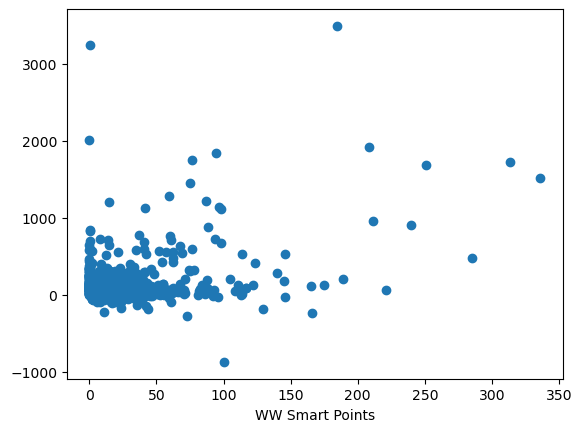

In [30]:
# UNHEALTHY RECIPES - PDV well outside the range
x_values = outside_pdv['sat_fat_g']
y_values = outside_pdv['wws_points']
fig, ax = plt.subplots()
ax.scatter(x_values, y_values)
ax.set_xlabel("WW Smart Points")
plt.show()

### Column: 'minutes'

#### Explore outliers

In [31]:
# Identify recipes with '0' minutes cooking time
zeromin_recipes = within_pdv.loc[within_pdv['minutes'] == 0]
print(f'zeromin_recipes: {zeromin_recipes.shape}')
zeromin_recipes.sort_values(by='minutes', ascending=False)

zeromin_recipes: (9, 29)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
77550,egg white french toast,4667,0,1533,1999-11-17,"['15-minutes-or-less', 'time-to-make', 'course...","[182.4, 4.0, 22.0, 14.0, 18.0, 5.0, 9.0]",7,"['in medium bowl beat egg whites well', 'add m...",NaN,...,18.0,5.0,9.0,2.60,11.0,0.336,9.0,1.0,27.0,10
78807,empanadas de honoro beef turnovers,3198,0,1796,1999-10-08,"['15-minutes-or-less', 'time-to-make', 'course...","[690.4, 60.0, 18.0, 14.0, 48.0, 52.0, 20.0]",12,['marinate beef in a glass bowl with the juice...,NaN,...,48.0,52.0,20.0,39.00,9.0,0.336,24.0,10.4,60.0,11
122663,lomo de cerdo,2700,0,1670,1999-09-03,"['15-minutes-or-less', 'time-to-make', 'course...","[128.6, 12.0, 10.0, 1.0, 17.0, 7.0, 1.0]",5,['remove the rind from the pork brown the pork...,"in my recipe book, the complete spanish cookbo...",...,17.0,7.0,1.0,7.80,5.0,0.024,8.5,1.4,3.0,2
129235,maultaschen swabian pockets,2758,0,1662,1999-08-22,"['15-minutes-or-less', 'time-to-make', 'course...","[723.2, 43.0, 18.0, 27.0, 61.0, 50.0, 28.0]",18,"['combine the flour , eggs , and salt in a bow...",it has been said that 'maultaschen' were origi...,...,61.0,50.0,28.0,27.95,9.0,0.648,30.5,10.0,84.0,6
143438,okonomiyaki japanese pizza,4608,0,1556,1999-11-16,"['15-minutes-or-less', 'time-to-make', 'course...","[326.9, 25.0, 24.0, 17.0, 15.0, 13.0, 11.0]",21,['toast the nori by waving it over a flame unt...,i'm told that this is authentic and that it is...,...,15.0,13.0,11.0,16.25,12.0,0.408,7.5,2.6,33.0,18
161228,potato pancakes german style,4247,0,1544,1999-11-11,"['15-minutes-or-less', 'time-to-make', 'course...","[259.1, 4.0, 11.0, 20.0, 18.0, 4.0, 16.0]",9,['keep potatoes covered with cold water until ...,NaN,...,18.0,4.0,16.0,2.60,5.5,0.480,9.0,0.8,48.0,6
181945,shrimp spring rolls goi cuon,4770,0,1533,1999-11-21,"['15-minutes-or-less', 'time-to-make', 'course...","[18.2, 0.0, 1.0, 1.0, 5.0, 0.0, 0.0]",10,['soak noodles in hot water for 15 to 20 mins ...,NaN,...,5.0,0.0,0.0,0.00,0.5,0.024,2.5,0.0,0.0,-1
203686,tammi rodriguez s secret garden fresh salsa,5417,0,2004,1999-12-13,"['15-minutes-or-less', 'time-to-make', 'course...","[76.8, 1.0, 39.0, 1.0, 7.0, 0.0, 5.0]",2,['put all items in blender and chop for 30-60 ...,authentic recipe from old mexico. passed down ...,...,7.0,0.0,5.0,0.65,19.5,0.024,3.5,0.0,15.0,22
211651,tricolor crustless quiche,707,0,39547,1999-08-08,"['15-minutes-or-less', 'time-to-make', 'course...","[508.2, 41.0, 17.0, 15.0, 42.0, 80.0, 15.0]",15,"['preheat oven to 375 degrees f', 'for frozen ...",here's an interesting and colorful quiche recipe!,...,42.0,80.0,15.0,26.65,8.5,0.360,21.0,16.0,45.0,10


In [32]:
# Get the upper bounds value from the 'minutes' column
minutes_upper = calc_stats.loc['upper_bounds', 'minutes']

# Identify recipes with very long cooking times
long_recipes = within_pdv.loc[within_pdv['minutes'] > minutes_upper]
print(f'long_recipes: {long_recipes.shape}')
long_recipes.sort_values(by='minutes', ascending=False)

long_recipes: (445, 29)


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
83008,flavored vinegar,479702,64815,1195537,2012-05-21,"['time-to-make', 'course', 'cuisine', 'prepara...","[15.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",7,"['collect the number of bottles necessary , wi...","adapted from the book ""the french farmhouse ki...",...,0.0,0.0,0.0,0.00,0.0,0.000,0.0,0.0,0.0,0
133590,mint oil,72352,20160,6357,2003-10-02,"['weeknight', 'time-to-make', 'course', 'cuisi...","[7.7, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",6,"['add oil to the pounded mint leaves , a littl...","from the foodcourt column, weekend magazine.",...,0.0,0.0,0.0,0.65,0.0,0.000,0.0,0.0,0.0,0
35511,caribbean ginger beer,504961,10090,163112,2013-07-30,"['time-to-make', 'course', 'main-ingredient', ...","[82.3, 0.0, 80.0, 0.0, 0.0, 0.0, 7.0]",11,"['wash and scrape the skin off the ginger', 'g...",this is not 'beer' as most think of it. there...,...,0.0,0.0,7.0,0.00,40.0,0.000,0.0,0.0,21.0,51
109012,infused sake,172527,10085,57695,2006-06-15,"['time-to-make', 'course', 'cuisine', 'prepara...","[265.8, 0.0, 14.0, 0.0, 2.0, 0.0, 4.0]",6,"[""in a 4- to 6-cup widemouthed jar , make sure...",posting for world tour ii. this is really good...,...,2.0,0.0,4.0,0.00,7.0,0.000,1.0,0.0,12.0,16
207403,the french picnic baguette pan bagnat,253323,7210,242729,2007-09-17,"['time-to-make', 'course', 'main-ingredient', ...","[458.3, 13.0, 18.0, 31.0, 53.0, 11.0, 22.0]",12,"['cut the baguette into even size portions', '...","this delightful sandwich from nice, in the sou...",...,53.0,11.0,22.0,8.45,9.0,0.744,26.5,2.2,66.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189593,spanish chicken with vegetables and olives p...,483466,135,1706426,2012-07-16,"['time-to-make', 'main-ingredient', 'cuisine',...","[717.2, 77.0, 16.0, 42.0, 110.0, 85.0, 2.0]",9,"['preheat oven to 375', 'truss your chicken', ...",chilindron fefers to combining smoked ham wit...,...,110.0,85.0,2.0,50.05,8.0,1.008,55.0,17.0,6.0,-18
35736,carne en su jugo meat cooked in it s own juice,464022,135,1110406,2011-09-12,"['bacon', 'time-to-make', 'course', 'main-ingr...","[191.2, 14.0, 9.0, 6.0, 41.0, 18.0, 2.0]",11,['in a large frying pan cook all the bacon to ...,"""carne en su jugo"" translates to ""meat cooked ...",...,41.0,18.0,2.0,9.10,4.5,0.144,20.5,3.6,6.0,-8
83778,forevermama s spicy chicken quesadillas or bur...,483487,135,1783373,2012-07-16,"['weeknight', 'time-to-make', 'course', 'main-...","[544.2, 42.0, 27.0, 70.0, 64.0, 67.0, 14.0]",29,['combine chicken and taco seasoning mix in a ...,"though this is a recipe for quesadillas, i've ...",...,64.0,67.0,14.0,27.30,13.5,1.680,32.0,13.4,42.0,5
191649,spicy green chile verde pork,161036,135,55221,2006-03-22,"['time-to-make', 'course', 'main-ingredient', ...","[292.8, 25.0, 11.0, 18.0, 59.0, 20.0, 1.0]",17,"['place pork , onions , salt , pepper , cumin ...",a z'tejas-inspired dish that will make your li...,...,59.0,20.0,1.0,16.25,5.5,0.432,29.5,4.0,3.0,-12


In [33]:
# Remove recipes greater than the calculated upper bounds AND recipes with '0' minutes cooking time
clean_recipes = within_pdv.loc[(within_pdv['minutes'] < minutes_upper) & (within_pdv['minutes'] > 0)].copy()
print(f'clean_recipes: {clean_recipes.shape}')
clean_recipes.head()

# Output results to a csv
clean_recipes.to_csv('Output/clean_recipes.csv', index=False)

clean_recipes: (5046, 29)


#### Further Investigation: Long Recipes

In [34]:
# How many of the long recipes had PDV outliers?
pdv_long = one_cuisine.loc[one_cuisine['id'].isin(flat_pdv)]
pdv_long.sort_values(by='minutes', ascending=False)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
162096,preserved fresh lemons,209590,43230,242729,2007-02-06,"['time-to-make', 'course', 'main-ingredient', ...","[223.1, 7.0, 64.0, 2019.0, 13.0, 3.0, 21.0]",17,"['soak the lemons in water for 2 to 3 days , c...",i always have at least one jar of preserved le...,...,13.0,3.0,21.0,4.55,32.0,48.456,6.5,0.6,63.0,39
116508,la brea starter and rustic bread,56466,8665,10404,2003-03-17,"['weeknight', 'time-to-make', 'course', 'cuisi...","[6210.8, 92.0, 168.0, 314.0, 332.0, 48.0, 408.0]",39,"['for the starter~', 'stir the flour and water...",this recipe is posted by request and is from t...,...,332.0,48.0,408.0,59.80,84.0,7.536,166.0,9.6,1224.0,130
23132,biltong,207260,5760,111075,2007-01-23,"['time-to-make', 'course', 'main-ingredient', ...","[711.5, 113.0, 6.0, 95.0, 17.0, 153.0, 0.0]",20,"['trim excess fat off the meat', 'slice meat a...",biltong is one of those things that everyone h...,...,17.0,153.0,0.0,73.45,3.0,2.280,8.5,30.6,0.0,25
170470,rillettes anthony bourdain at les halles,319679,4680,638072,2008-08-15,"['time-to-make', 'course', 'main-ingredient', ...","[1236.2, 195.0, 0.0, 15.0, 40.0, 269.0, 0.0]",10,['place the pork belly and shoulder in a heavy...,"i quote anthony bourdain ""jesus this dish is e...",...,40.0,269.0,0.0,126.75,0.0,0.360,20.0,53.8,0.0,33
21344,bergischer sauerbraten,494576,4500,471300,2013-02-02,"['time-to-make', 'course', 'main-ingredient', ...","[569.3, 32.0, 23.0, 48.0, 130.0, 49.0, 4.0]",14,"['peel and cube veggies in about 1 cm pieces',...",sauerbraten is a dish that is traditional from...,...,130.0,49.0,4.0,20.80,11.5,1.152,65.0,9.8,12.0,-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158734,pomegranate mojito with vanilla sugar,166017,2,169969,2006-04-27,"['15-minutes-or-less', 'time-to-make', 'course...","[3224.4, 0.0, 3197.0, 1.0, 0.0, 0.0, 266.0]",11,"['rim cocktail glass with vanilla sugar', 'com...",unusual mojito recipe that uses vanilla sugar ...,...,0.0,0.0,266.0,0.00,1598.5,0.024,0.0,0.0,798.0,2017
23807,black bean salsa ii,5433,0,1875,1999-12-13,"['15-minutes-or-less', 'time-to-make', 'course...","[997.5, 29.0, 69.0, 98.0, 89.0, 10.0, 60.0]",6,"['drain & rinse corn & beans , add cilantro , ...","this tastes better than it sounds, and really ...",...,89.0,10.0,60.0,18.85,34.5,2.352,44.5,2.0,180.0,29
92283,gorditas,1649,0,1534,1999-09-29,"['15-minutes-or-less', 'time-to-make', 'course...","[1018.6, 132.0, 3.0, 104.0, 32.0, 176.0, 15.0]",9,"['fry beef and onion together', 'season with s...",NaN,...,32.0,176.0,15.0,85.80,1.5,2.496,16.0,35.2,45.0,27
108548,indian chili chicken with onions,34058,0,23302,2002-07-15,"['15-minutes-or-less', 'time-to-make', 'course...","[1019.5, 122.0, 67.0, 90.0, 81.0, 71.0, 13.0]",17,"['heat oil in a wok', 'put in onions and fry u...",this is supposedly very similar to the chicken...,...,81.0,71.0,13.0,79.30,33.5,2.160,40.5,14.2,39.0,36


In [35]:
pdv_mins = pdv_long.loc[pdv_long['minutes'] > minutes_upper]
print(f'Recipes with PDV outliers: {pdv_long.shape[0]}')
print(f'Long recipes with PDV outliers: {pdv_mins.shape[0]}')

Recipes with PDV outliers: 1640
Long recipes with PDV outliers: 240


In [36]:
# How many of the long recipes are highly rated?
best_long = long_recipes.loc[long_recipes['rating'] == 5].copy()
best_long['minutes'].describe()

count      212.000000
mean       992.938679
std       4781.415208
min        135.000000
25%        160.000000
50%        210.000000
75%        450.000000
max      64815.000000
Name: minutes, dtype: float64

### Column: 'wws_points'

#### Explore outliers

In [37]:
# Get the descriptive statistics summary
clean_descript = clean_recipes['wws_points'].describe()
clean_descript

count    5046.000000
mean        8.986128
std        16.408747
min       -44.000000
25%         0.000000
50%         6.000000
75%        16.000000
max        73.000000
Name: wws_points, dtype: float64

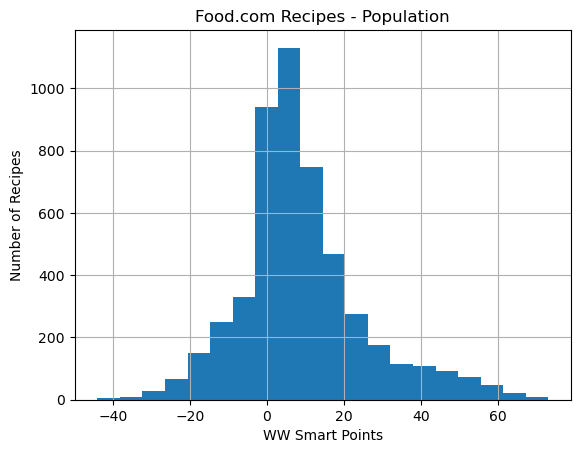

In [38]:
# Create a histogram of the points
clean_recipes['wws_points'].hist(bins=20)
plt.title("Food.com Recipes - Population")
plt.xlabel("WW Smart Points")
plt.ylabel("Number of Recipes")
plt.show()

ShapiroResult(statistic=0.9475691914558411, pvalue=2.617242794017427e-12)

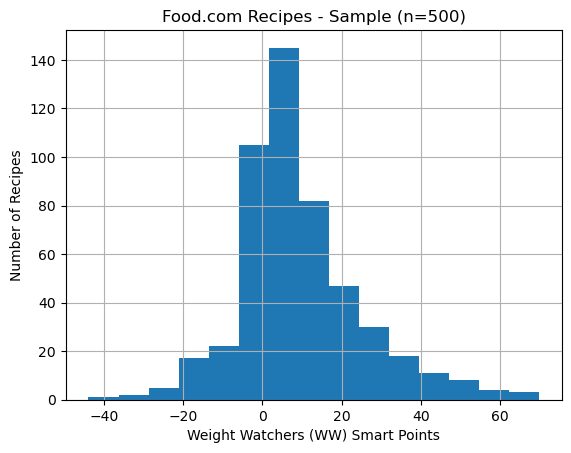

In [39]:
# Check for Gaussian distribution - using Shapiro-Wilk test
# Note: Shapiro-Wilk is sensitive to sample size
sample_size = 500
sample_set = clean_recipes['wws_points'].sample(n=sample_size)
sample_set.hist(bins=15)
plt.title(f"Food.com Recipes - Sample (n={sample_size})")
plt.xlabel("Weight Watchers (WW) Smart Points")
plt.ylabel("Number of Recipes")

stats.shapiro(sample_set)
# A very high W-statistic suggests a good fit to a normal distribution.
# A near-zero p-value, for a Shapiro-Wilk test, rejects the null hypothesis, meaning NOT a normal distribution.

#### Further Investigation: Does removing outliers result in a Normal Distribution?
* Answer: Higher W-statistic, slightly better p-value but still near-zero. Still __not a normal distribution.__

In [40]:
# Get clean_recipes['wws_points'] outliers
points_outliers = add_iqr(clean_descript)
points_outliers

count           5046.000000
mean               8.986128
std               16.408747
min              -44.000000
25%                0.000000
50%                6.000000
75%               16.000000
max               73.000000
iqr               16.000000
lower_bounds     -24.000000
upper_bounds      40.000000
dtype: float64

ShapiroResult(statistic=0.9872962832450867, pvalue=0.00024026594473980367)

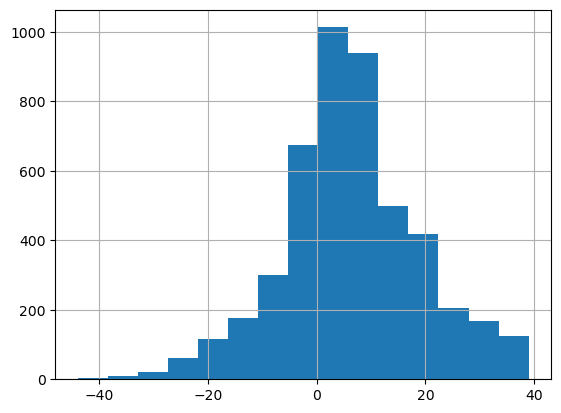

In [41]:
clean_recipes1 = clean_recipes.loc[clean_recipes['wws_points'] < points_outliers.upper_bounds]
clean_recipes1['wws_points'].hist(bins=15)

sample_set1 = clean_recipes1['wws_points'].sample(n=500)
stats.shapiro(sample_set1)
# Removing outliers creates in a higher W-statistic, however the p-value is still near-zero.

## Nutritional Values Correlation

In [43]:
# Create a DataFrame of points of interest for the correlation calculation
pdv_cut = clean_recipes[[
    'rating', 'Calories', 'Total Fat (PDV)',
    'Sugar (PDV)', 'Sodium (PDV)', 'Protein (PDV)',
    'Saturated Fat (PDV)', 'Carbohydrates (PDV)']]

# Calculate the correlation matrix
corr_matrix = round(pdv_cut.corr(), 2)
corr_matrix

# Create a heatmap based on the results
corr_matrix.style.background_gradient(cmap='Blues')

,rating,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV)
rating,1.000000,0.040000,0.060000,-0.000000,0.040000,0.010000,0.050000,-0.010000
Calories,0.040000,1.000000,0.850000,0.160000,0.550000,0.750000,0.710000,0.610000
Total Fat (PDV),0.060000,0.850000,1.000000,0.020000,0.440000,0.580000,0.840000,0.200000
Sugar (PDV),-0.000000,0.160000,0.020000,1.000000,0.020000,0.010000,0.020000,0.340000
Sodium (PDV),0.040000,0.550000,0.440000,0.020000,1.000000,0.520000,0.400000,0.330000
Protein (PDV),0.010000,0.750000,0.580000,0.010000,0.520000,1.000000,0.490000,0.250000
Saturated Fat (PDV),0.050000,0.710000,0.840000,0.020000,0.400000,0.490000,1.000000,0.140000
Carbohydrates (PDV),-0.010000,0.610000,0.200000,0.340000,0.330000,0.250000,0.140000,1.000000


## Initial Visualisation

### Meal Types

In [44]:
# Isolate 'breakfast, lunch, dinner' from clean_recipes
meal_df = clean_recipes.groupby(['meal_type']).median(numeric_only=True)
meal_df = meal_df.drop(columns=['id', 'contributor_id'])
meal_df

,minutes,n_steps,n_ingredients,rating,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
meal_type,,,,,,,,,,,,,,,,,,
breakfast,26.0,10.0,8.0,5.000000,287.5,24.0,13.0,15.0,24.0,27.0,7.0,15.6,6.5,0.360,12.0,5.4,21.0,5.0
dinner,35.0,9.0,10.0,4.875000,268.8,20.0,15.0,12.0,18.0,18.0,5.0,13.0,7.5,0.288,9.0,3.6,15.0,7.0
lunch,30.0,9.0,9.0,4.833333,297.0,20.0,13.0,19.0,26.0,18.0,8.0,13.0,6.5,0.456,13.0,3.6,24.0,5.0


In [45]:
# Bin by `wws_points` then groupby each meal type
min_points = clean_recipes['wws_points'].describe().min()
max_points = clean_recipes['wws_points'].describe().max()

# Create bins
points_bins = np.arange(min_points+16, max_points, 16) # CHANGE BETWEEN 10 and 16, and look at PLOT!
points_labels = [f'{points_bins[i]} to {points_bins[i+1]}' for i in range(len(points_bins)-1)]
bins_df = pd.cut(clean_recipes['wws_points'], bins=points_bins, labels=points_labels)

# Set the index and its name
points_df = clean_recipes.set_index(bins_df)
points_df.index.name = "WWS Point Ranges"

# Create grouped DataFrame by numeric means
binned_df = points_df.groupby(['WWS Point Ranges', 'meal_type']).median(numeric_only=True) # originally mean
binned_df

id  minutes  contributor_id  n_steps  \
WWS Point Ranges meal_type                                               
-28.0 to -12.0   breakfast  162303.5     17.5        128026.0      7.5   
                 dinner     166910.5     40.0        117612.0     10.0   
                 lunch      170857.0     30.0        134663.0      8.0   
-12.0 to 4.0     breakfast  240216.0     25.0        169430.0      9.0   
                 dinner     189809.0     35.0        149363.0      9.0   
                 lunch      189988.0     25.0        164438.0      9.0   
4.0 to 20.0      breakfast  253543.5     30.0        185170.0     10.0   
                 dinner     182320.0     35.0        142361.0      9.0   
                 lunch      169158.0     30.0        141293.0      9.0   
20.0 to 36.0     breakfast  295196.5     30.0        169969.0     10.0   
                 dinner     182589.0     35.0        136726.0      9.0   
                 lunch      135860.5     35.0         80353.0      9.5   
36.0 to 52.0     breakfast  174437.5     20.0        215882.0      7.0   
                 dinner     183063.0     30.0        136726.0     10.0   
                 lunch      190540.0     30.0         71324.0      9.0   
52.0 to 68.0     breakfast  255380.0     40.0        174331.0     10.0   
                 dinner     220556.0     27.0        149363.0      8.0   
                 lunch      207389.0     30.0        217226.0     11.0   
68.0 to 84.0     breakfast       NaN      NaN             NaN      NaN   
                 dinner     217092.5     22.5        125297.5      9.0   
                 lunch           NaN      NaN             NaN      NaN   

                            n_ingredients    rating  Calories  \
WWS Point Ranges meal_type                                      
-28.0 to -12.0   breakfast            7.0  5.000000    430.35   
                 dinner              10.0  4.833333    386.80   
                 lunch               10.0  4.956522    340.80   
-12.0 to 4.0     breakfast            8.0  5.000000    278.50   
                 dinner              10.0  4.857143    262.60   
                 lunch                9.0  4.833333    273.35   
4.0 to 20.0      breakfast            9.0  4.908333    297.60   
                 dinner              10.0  4.880952    247.70   
                 lunch               10.0  4.800000    305.80   
20.0 to 36.0     breakfast            8.5  5.000000    297.35   
                 dinner              10.0  4.888889    260.70   
                 lunch               11.0  4.825758    324.65   
36.0 to 52.0     breakfast            6.0  4.870588    239.75   
                 dinner               8.0  5.000000    268.80   
                 lunch                9.0  4.833333    319.90   
52.0 to 68.0     breakfast            8.5  5.000000    310.60   
                 dinner               8.0  5.000000    283.00   
                 lunch               10.0  5.000000    275.60   
68.0 to 84.0     breakfast            NaN       NaN       NaN   
                 dinner               6.0  4.500000    558.20   
                 lunch                NaN       NaN       NaN   

                            Total Fat (PDV)  Sugar (PDV)  Sodium (PDV)  \
WWS Point Ranges meal_type                                               
-28.0 to -12.0   breakfast             46.0          5.0          39.5   
                 dinner                27.5          7.0          20.0   
                 lunch                 24.0          7.0          19.0   
-12.0 to 4.0     breakfast             25.0          6.0          20.0   
                 dinner                18.0          6.0          15.0   
                 lunch                 18.0          7.0          18.0   
4.0 to 20.0      breakfast             24.5         17.0          14.0   
                 dinner                19.0         16.0          12.0   
                 lunch                 22.0         17.0          20.0   
20.0 to 36.0     brea

The r-value is: nan


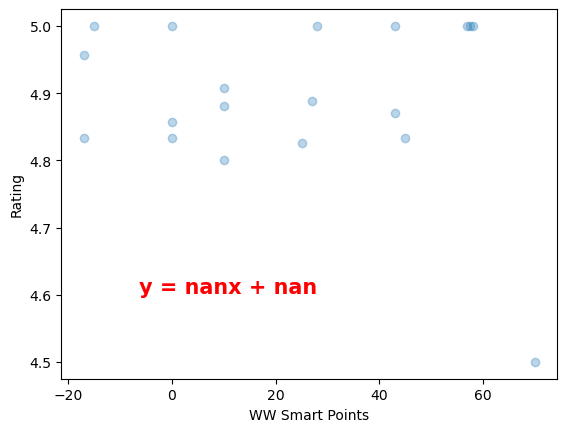

In [46]:
x_val = binned_df['wws_points']
y_val = binned_df['rating']
fig, ax = plt.subplots()
ax.scatter(x_val, y_val, alpha=0.3)
ax.set_xlabel("WW Smart Points")
ax.set_ylabel("Rating")
# ax.plot(x_val, y_val)
linreg_plot(ax, x_val, y_val, 100, 100)

## RESEARCH HOW TO PLOT MULTI-INDEX DATAFRAME

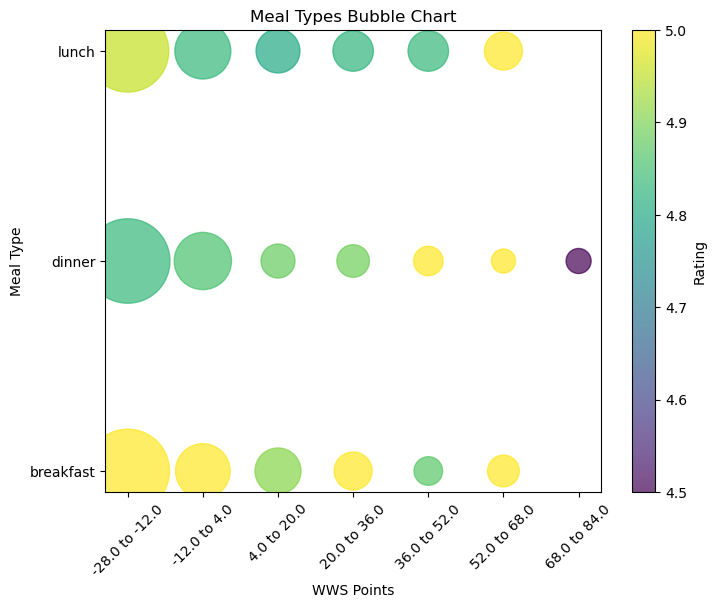

In [47]:
# Extract data for plotting
x = binned_df.index.get_level_values('WWS Point Ranges')
y = binned_df.index.get_level_values('meal_type')
size = binned_df['protein_g']*10  # Size of the bubbles
colour = binned_df['rating']  # Color of the bubbles

# Create the bubble chart
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(x, y, s=size * 10, c=colour, cmap='viridis', alpha=0.7)

# Add labels and a colorbar
ax.set_xlabel('WWS Points')
plt.xticks(rotation=45)
ax.set_ylabel('Meal Type')
ax.set_title('Meal Types Bubble Chart')
cbar = plt.colorbar(scatter)
cbar.set_label('Rating')

plt.show()

In [48]:
# THOUGHTS: Group by ratings instead? Rather than points? More robust and less iffy that way?
# ANSWER: Tried it, doesn't really work!

In [49]:
updated_types = clean_recipes['meal_type'].unique()
updated_types = ['breakfast', 'lunch', 'dinner']

# Breakfast
breakfast = clean_recipes.loc[clean_recipes['meal_type'] == "breakfast"].copy()
print(f'breakfast: {breakfast.shape}')

# Lunch
lunch = clean_recipes.loc[clean_recipes['meal_type'] == "lunch"].copy()
print(f'lunch: {lunch.shape}')

# Dinner
dinner = clean_recipes.loc[clean_recipes['meal_type'] == "dinner"].copy()
print(f'dinner: {dinner.shape}')

breakfast: (519, 29)
lunch: (1403, 29)
dinner: (3124, 29)


breakfast R-value: 0.55
lunch R-value: 0.37
dinner R-value: 0.29


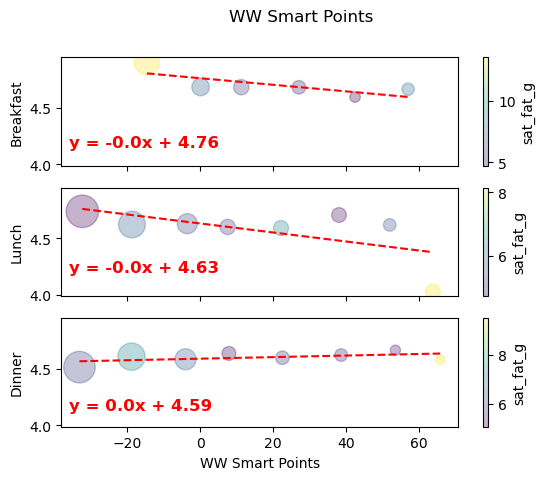

In [50]:
fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle("WW Smart Points")
x_col = 'wws_points'
y_col = 'rating'
size_col = 'protein_g'
colour_col = 'sat_fat_g'

df_list = [breakfast, lunch, dinner]

for idx, val in enumerate(df_list):

    # Bin by `wws_points`
    min_points = df_list[idx]['wws_points'].describe().min()
    max_points = df_list[idx]['wws_points'].describe().max()
    
    # Create bins
    points_bins = np.arange(min_points, max_points, 15) # 5 was good with less granular cuisines
    points_labels = [f'{points_bins[i]} to {points_bins[i+1]}' for i in range(len(points_bins)-1)]
    bins_df = pd.cut(df_list[idx]['wws_points'], bins=points_bins, labels=points_labels)
    
    # Set the index and its name
    points_df = df_list[idx].set_index(bins_df)
    points_df.index.name = "WWS Point Ranges"
    
    # Create grouped DataFrame by numeric means
    binned_df = points_df.groupby(['WWS Point Ranges']).mean(numeric_only=True) # originally mean
    binned_df

    # Extract x- and y-values
    x = binned_df[x_col]
    y = binned_df[y_col]
    size = binned_df[size_col]
    colour = binned_df[colour_col]

    scatter_plot = axs[idx].scatter(x, y, s=size*10, alpha=0.3, c=colour)
    axs[2].set_xlabel('WW Smart Points')
    axs[idx].set_ylabel(updated_types[idx].title())
    cbar = plt.colorbar(scatter_plot)
    cbar.set_label(colour_col)

    (slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x, y)
    line_equation = f'y = {round(slope, 2)}x + {round(intercept, 2)}'
    regression_values = slope * x + intercept
    axs[idx].plot(x, regression_values, linestyle='--', c='red')
    if idx == 0:
        x_coord, y_coord = 50, 240
    elif idx == 1:
        x_coord, y_coord = 50, 150
    elif idx == 2:
        x_coord, y_coord = 50, 50
    axs[idx].annotate(line_equation, xy=(x_coord, y_coord), xycoords='figure points',
        fontsize = 12, color='red', weight='bold')

    print(f'{updated_types[idx]} R-value: {round(rvalue**2, 2)}')

fig.savefig('Meal types and WW Smart Points1.png')

In [51]:
# Bin and count to get percentages?
meal_median = []
for idx, val in enumerate(df_list):
    meal_median.append(df_list[idx]['wws_points'].describe()['50%'])
mealmedian_avg = np.mean(meal_median)
mealmedian_avg # Cut off for healthiness

# THIS WOULD JUST MAKE IT 50% healthy and 50% unhealthy???
# Use nutritional values instead, and create percentage comparisons based on how many exceed all values? Is this realistic?

5.666666666666667

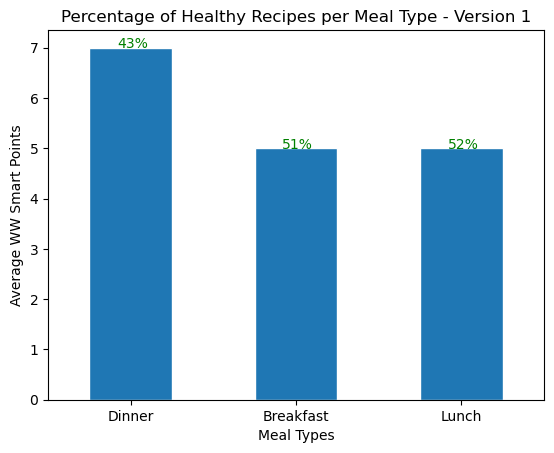

In [52]:
# Create a DataFrame grouped by the means of each cuisine
meal_df = clean_recipes.groupby(['meal_type']).median(numeric_only=True)

# Get percentage of "healthy" recipes per cuisine
# Set the limit as the median 'wws_points'
wws_median = clean_recipes['wws_points'].describe()['50%']

# Get the total number of recipes per cuisine
meal_count = clean_recipes.groupby(['meal_type'])['id'].count()

# Create a DataFrame of recipes that sit above the median 'wws_points'
healthy_count = clean_recipes.loc[clean_recipes['wws_points'] < wws_median]

# Create a groupby DataFrame that counts the number of healthy recipes
healthy_group = healthy_count.groupby(['meal_type'])['id'].count()

# Calculate the percentage value
percent_healthy = []
for idx in range(len(meal_count)):
    percent_healthy.append(int(healthy_group[idx] * 100 / meal_count[idx]))

# Create a DataFrame with calculated percentages, add the average WWS Points as a new column
percent_df = pd.DataFrame(percent_healthy, index=healthy_group.index, columns=['percent_healthy'])
percent_df['ave_wws_points'] = meal_df['wws_points']

# Sort the values and reset index to recover 'cuisine'
percent_df = percent_df.sort_values(by=['ave_wws_points'], ascending=False).reset_index()

# Plot the bar chart
bar_chart = percent_df['ave_wws_points'].plot(
    kind = "bar",
    title = "Percentage of Healthy Recipes per Meal Type - Version 1",
    edgecolor = "white")

# Set the labels
bar_chart.set_xlabel("Meal Types")
bar_chart.set_ylabel("Average WW Smart Points")
cuisine_titles = [word.title() for word in percent_df['meal_type']]
bar_chart.set_xticklabels(
    cuisine_titles,
    rotation_mode='default',
    rotation=0)

# Annotate the bar chart with the percentage values
for index, row in percent_df.iterrows():
    plt.annotate(
        f"{row['percent_healthy']}%", color="green",
        xy=(row.name, meal_df[meal_df.index == row['meal_type']]['wws_points']),
        xytext=(-10,0), textcoords='offset points')

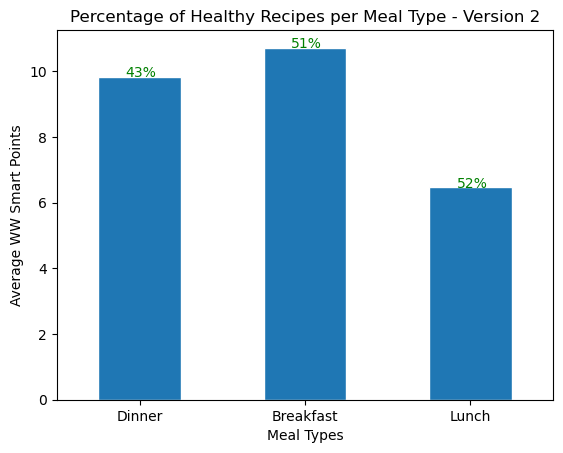

In [53]:
# Create a DataFrame grouped by the means of each cuisine
meal_df = clean_recipes.groupby(['meal_type']).mean(numeric_only=True)

# Get percentage of "healthy" recipes per cuisine
# Set the limit as the median 'wws_points'
wws_median = clean_recipes['wws_points'].describe()['50%']

# Get the total number of recipes per cuisine
meal_count = clean_recipes.groupby(['meal_type'])['id'].count()

# Create a DataFrame of recipes that sit above the median 'wws_points'
healthy_count = clean_recipes.loc[clean_recipes['wws_points'] < wws_median]

# Create a groupby DataFrame that counts the number of healthy recipes
healthy_group = healthy_count.groupby(['meal_type'])['id'].count()

# Calculate the percentage value
percent_healthy = []
for idx in range(len(meal_count)):
    percent_healthy.append(int(healthy_group[idx] * 100 / meal_count[idx]))

# Create a DataFrame with calculated percentages, add the average WWS Points as a new column
percent_df = pd.DataFrame(percent_healthy, index=healthy_group.index, columns=['percent_healthy'])
percent_df['ave_wws_points'] = meal_df['wws_points']

# Sort the values and reset index to recover 'cuisine'
percent_df = percent_df.sort_values(by=['percent_healthy'], ascending=True).reset_index()

# Plot the bar chart
bar_chart = percent_df['ave_wws_points'].plot(
    kind = "bar",
    title = "Percentage of Healthy Recipes per Meal Type - Version 2",
    edgecolor = "white")

# Set the labels
bar_chart.set_xlabel("Meal Types")
bar_chart.set_ylabel("Average WW Smart Points")
cuisine_titles = [word.title() for word in percent_df['meal_type']]
bar_chart.set_xticklabels(
    cuisine_titles,
    rotation_mode='default',
    rotation=0)

# Annotate the bar chart with the percentage values
for index, row in percent_df.iterrows():
    plt.annotate(
        f"{row['percent_healthy']}%", color="green",
        xy=(row.name, meal_df[meal_df.index == row['meal_type']]['wws_points']),
        xytext=(-10,0), textcoords='offset points')

### Cuisines

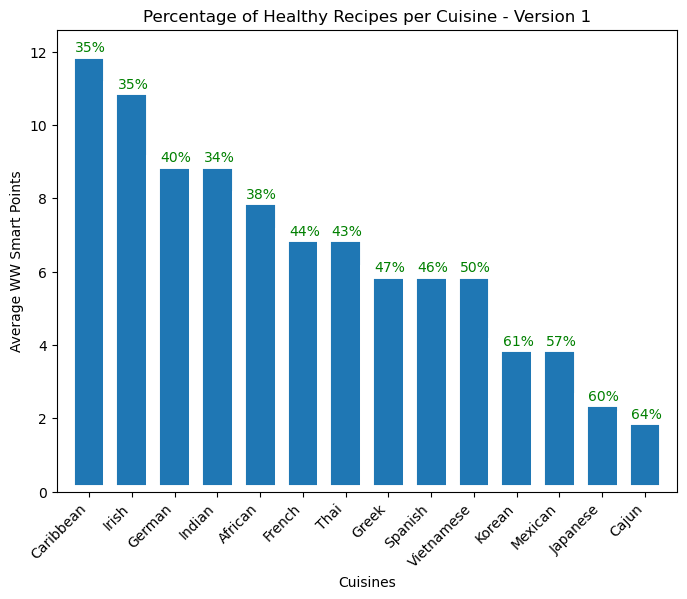

In [54]:
# Create a DataFrame grouped by the means of each cuisine
cuisine_df = clean_recipes.groupby(['cuisine']).median(numeric_only=True)

# Get percentage of "healthy" recipes per cuisine
# Set the limit as the median 'wws_points'
wws_median = clean_recipes['wws_points'].describe()['50%']

# Get the total number of recipes per cuisine
cuisine_count = clean_recipes.groupby(['cuisine'])['id'].count()

# Create a DataFrame of recipes that sit above the median 'wws_points'
healthy_count = clean_recipes.loc[clean_recipes['wws_points'] < wws_median]

# Create a groupby DataFrame that counts the number of healthy recipes
healthy_group = healthy_count.groupby(['cuisine'])['id'].count()

# Calculate the percentage value
percent_healthy = []
for idx in range(len(cuisine_count)):
    percent_healthy.append(int(healthy_group[idx] * 100 / cuisine_count[idx]))

# Create a DataFrame with calculated percentages, add the average WWS Points as a new column
percent_df = pd.DataFrame(percent_healthy, index=healthy_group.index, columns=['percent_healthy'])
percent_df['ave_wws_points'] = cuisine_df['wws_points']

# Sort the values and reset index to recover 'cuisine'
percent_df = percent_df.sort_values(by=['ave_wws_points'], ascending=False).reset_index()

# Plot the bar chart
bar_chart = percent_df['ave_wws_points'].plot(
    kind = "bar",
    title = "Percentage of Healthy Recipes per Cuisine - Version 1",
    figsize = (8,6),
    width = 1,
    linewidth = 10,
    edgecolor = "white")

# Set the labels
bar_chart.set_xlabel("Cuisines")
bar_chart.set_ylabel("Average WW Smart Points")
cuisine_titles = [word.title() for word in percent_df['cuisine']]
bar_chart.set_xticklabels(
    cuisine_titles,
    rotation_mode='default',
    rotation=45,
    ha='right')

# Annotate the bar chart with the percentage values
for index, row in percent_df.iterrows():
    plt.annotate(
        f"{row['percent_healthy']}%", color="green",
        xy=(row.name, cuisine_df[cuisine_df.index == row['cuisine']]['wws_points']),
        xytext=(-10,0), textcoords='offset points')

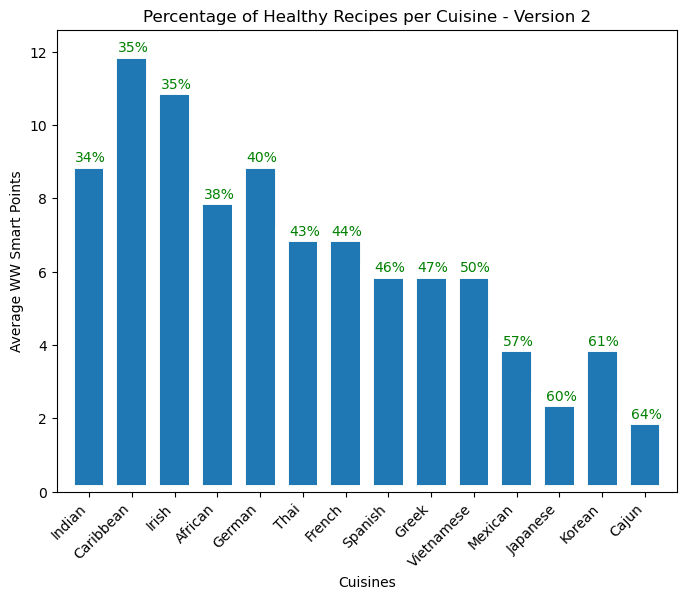

In [55]:
# Sort the values and reset index to recover 'cuisine'
percent_df = percent_df.sort_values(by=['percent_healthy'], ascending=True).reset_index()

# Plot the bar chart
bar_chart = percent_df['ave_wws_points'].plot(
    kind = "bar",
    title = "Percentage of Healthy Recipes per Cuisine - Version 2",
    figsize = (8,6),
    width = 1,
    linewidth = 10,
    edgecolor = "white")

# Set the labels
bar_chart.set_xlabel("Cuisines")
bar_chart.set_ylabel("Average WW Smart Points")
cuisine_titles = [word.title() for word in percent_df['cuisine']]
bar_chart.set_xticklabels(
    cuisine_titles,
    rotation_mode='default',
    rotation=45,
    ha='right')

# Annotate the bar chart with the percentage values
for index, row in percent_df.iterrows():
    plt.annotate(
        f"{row['percent_healthy']}%", color="green",
        xy=(row.name, cuisine_df[cuisine_df.index == row['cuisine']]['wws_points']),
        xytext=(-10,0), textcoords='offset points')

<Axes: >

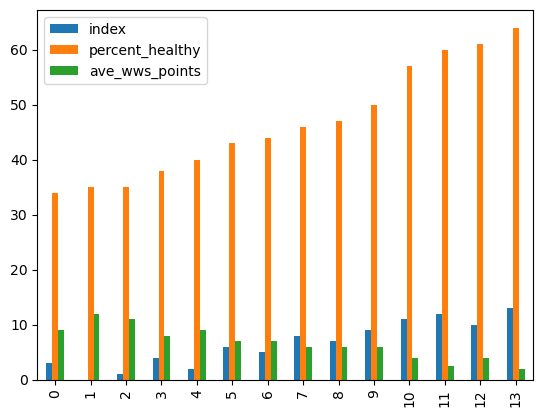

In [56]:
# Version 3 - This just looks messy, since combining two different y-axes!
percent_df.plot(kind="bar")

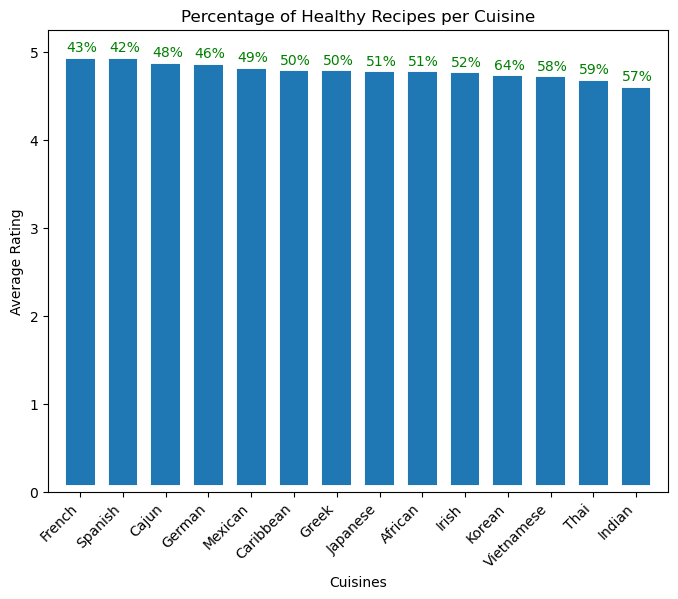

In [57]:
# Create a DataFrame grouped by the means of each cuisine
cuisine_df = clean_recipes.groupby(['cuisine']).median(numeric_only=True)

# Get percentage of "healthy" recipes per cuisine
# Set the limit as the median 'wws_points'
wws_median = clean_recipes['rating'].describe()['50%']

# Get the total number of recipes per cuisine
cuisine_count = clean_recipes.groupby(['cuisine'])['id'].count()

# Create a DataFrame of recipes that sit above the median 'wws_points'
healthy_count = clean_recipes.loc[clean_recipes['rating'] < wws_median]

# Create a groupby DataFrame that counts the number of healthy recipes
healthy_group = healthy_count.groupby(['cuisine'])['id'].count()

# Calculate the percentage value
percent_healthy = []
for idx in range(len(cuisine_count)):
    percent_healthy.append(int(healthy_group[idx] * 100 / cuisine_count[idx]))

# Create a DataFrame with calculated percentages, add the average WWS Points as a new column
percent_df = pd.DataFrame(percent_healthy, index=healthy_group.index, columns=['percent_healthy'])
percent_df['ave_rating'] = cuisine_df['rating']

# Sort the values and reset index to recover 'cuisine'
percent_df = percent_df.sort_values(by=['ave_rating'], ascending=False).reset_index()

# Plot the bar chart
bar_chart = percent_df['ave_rating'].plot(
    kind = "bar",
    title = "Percentage of Healthy Recipes per Cuisine",
    figsize = (8,6),
    width = 1,
    linewidth = 10,
    edgecolor = "white")

# Set the labels
bar_chart.set_xlabel("Cuisines")
bar_chart.set_ylabel("Average Rating")
cuisine_titles = [word.title() for word in percent_df['cuisine']]
bar_chart.set_xticklabels(
    cuisine_titles,
    rotation_mode='default',
    rotation=45,
    ha='right')

# Annotate the bar chart with the percentage values
for index, row in percent_df.iterrows():
    plt.annotate(
        f"{row['percent_healthy']}%", color="green",
        xy=(row.name, cuisine_df[cuisine_df.index == row['cuisine']]['rating']),
        xytext=(-10,0), textcoords='offset points')

In [58]:
# Get the latitudes and longitudes for each cuisine region
regions = ['Congo', 'Louisiana, USA', 'Caribbean', 'France', 'German', 'Greece', 'India',
       'Ireland', 'Japan', 'Korea', 'Mexico', 'Spain', 'Thailand', 'Vietnam']

api_response = request_latlong(regions)
lats = api_response[0]
longs = api_response[1]

In [59]:
cuisine_df['latitude'] = lats
cuisine_df['longitude'] = longs
cuisine_df

cuisine_df.to_csv('Output/cuisine_dataframe.csv', index=False)

In [60]:
cuisine_map = cuisine_df.hvplot.points(
    'longitude',
    'latitude',
    color = 'rating',
    # cmap = ['purple', 'red'],
    size = 'wws_points',
    scale = 30,
    alpha = 0.3,
    geo = True,
    tiles = "CartoLight",
    frame_width = 1000,
    frame_height = 800)
cuisine_map

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [longitude,latitude]   (rating,wws_points)

### Popularity

The r-value is: 0.08994565177659358


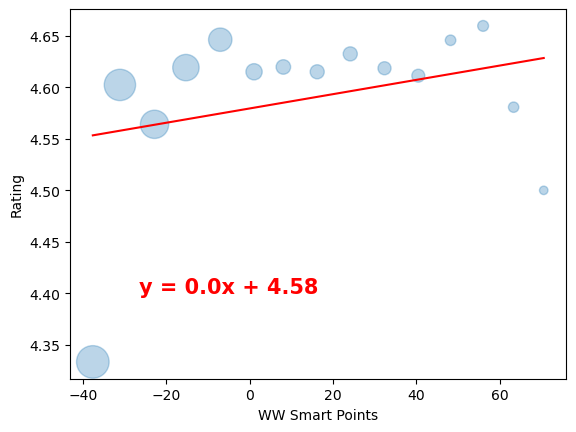

In [61]:
# Bin by `wws_points` then groupby each meal type
min_points = clean_recipes['wws_points'].describe().min()
max_points = clean_recipes['wws_points'].describe().max()

# Create bins
points_bins = np.arange(min_points, max_points, 8) # CHANGE BETWEEN 10 and 16, and look at PLOT!
bins_df = pd.cut(clean_recipes['wws_points'], bins=points_bins)

# Set the index and its name
points_df = clean_recipes.set_index(bins_df)
points_df.index.name = "WWS Point Ranges"

# Create grouped DataFrame by numeric means
binned_df = points_df.groupby(['WWS Point Ranges']).mean(numeric_only=True) # originally mean
# display(binned_df)

# Set the x- and y-values for the plot
x_val = binned_df['wws_points']
y_val = binned_df['rating']

fig, ax = plt.subplots()
ax.scatter(x_val, y_val, s=binned_df['protein_g']*10, alpha=0.3)
ax.set_xlabel("WW Smart Points")
ax.set_ylabel("Rating")
# ax.plot(x_val, y_val)
linreg_plot(ax, x_val, y_val, 100, 100)

1
The r-value is: 0.006855518497449373


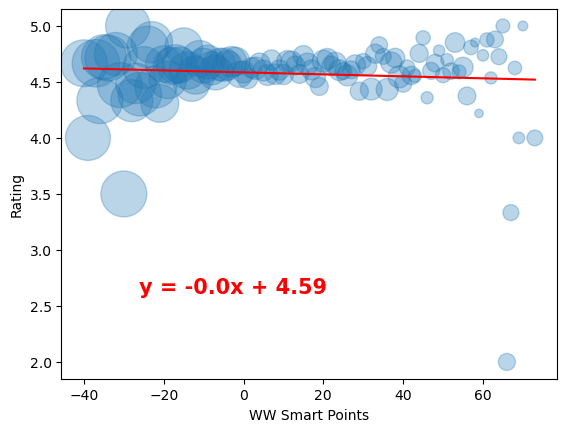

2
The r-value is: 0.01239302023861937


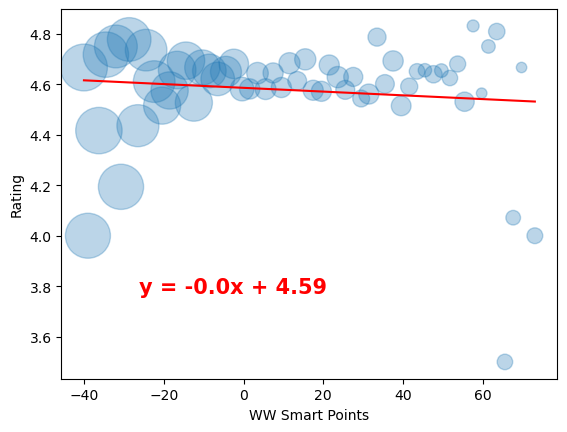

3
The r-value is: 0.03181279707142611


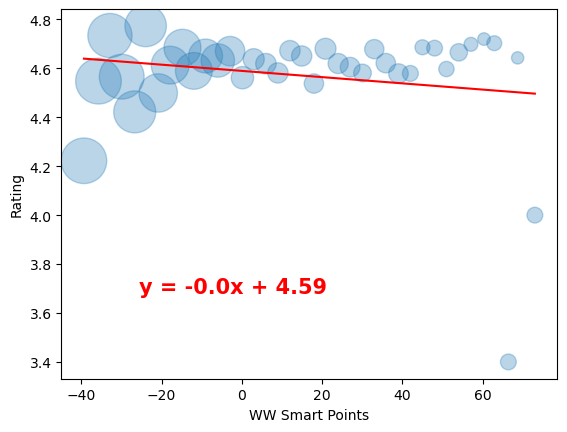

4
The r-value is: 0.0384507975043187


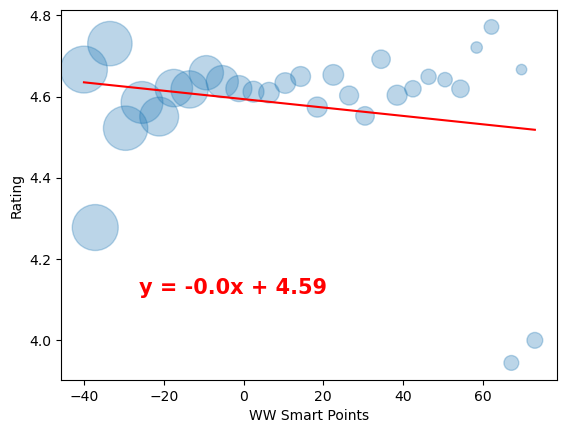

5
The r-value is: 0.025866789458751923


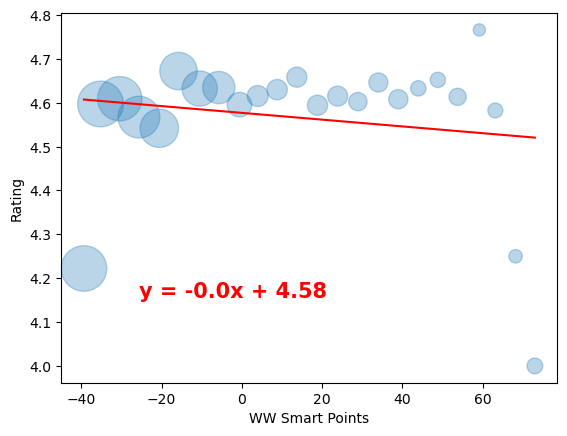

6
The r-value is: 0.0410014451782839


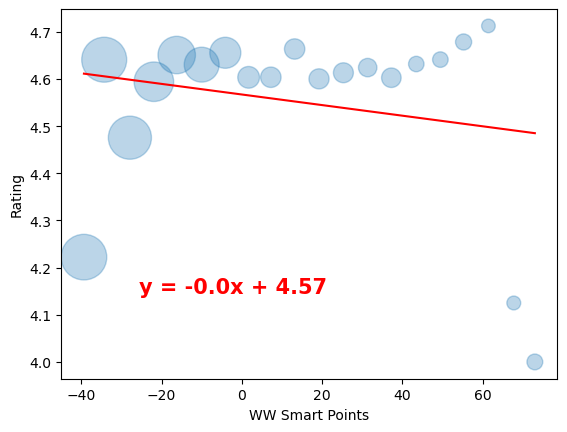

7
The r-value is: 0.04551863497668973


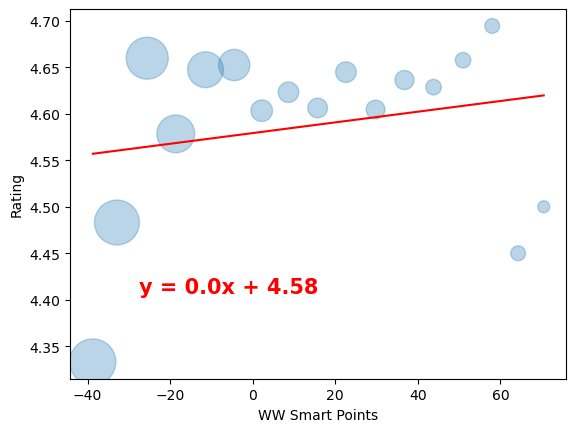

8
The r-value is: 0.08994565177659358


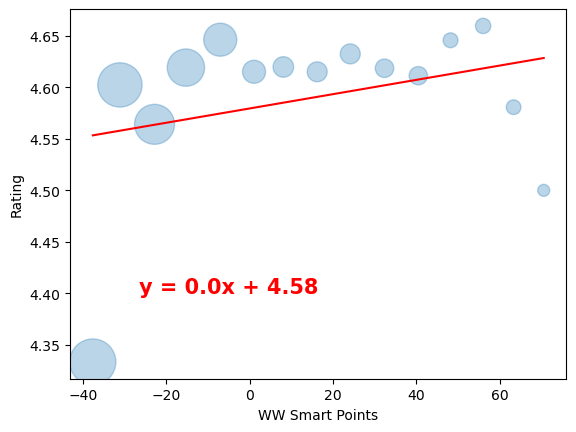

9
The r-value is: 0.01734480881321079


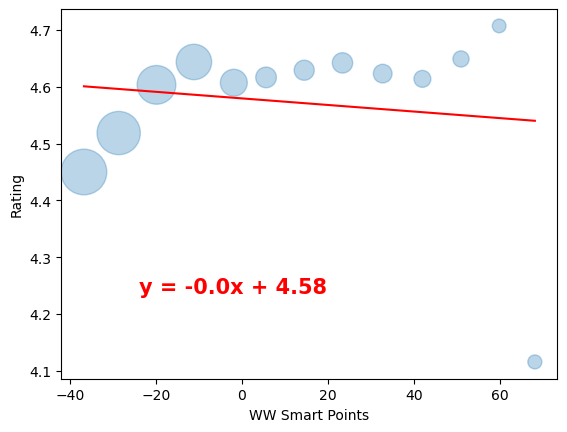

10
The r-value is: 0.039074149563200496


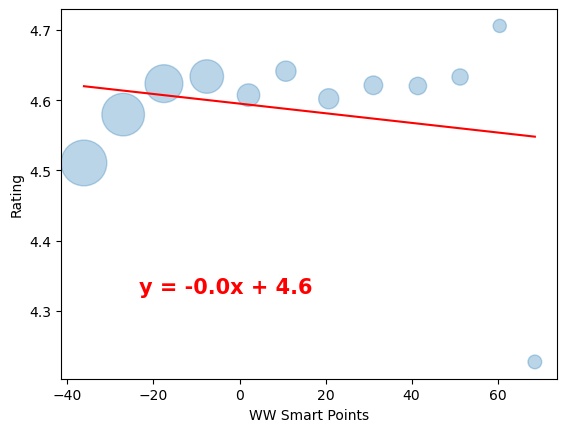

11
The r-value is: 0.050967453817875985


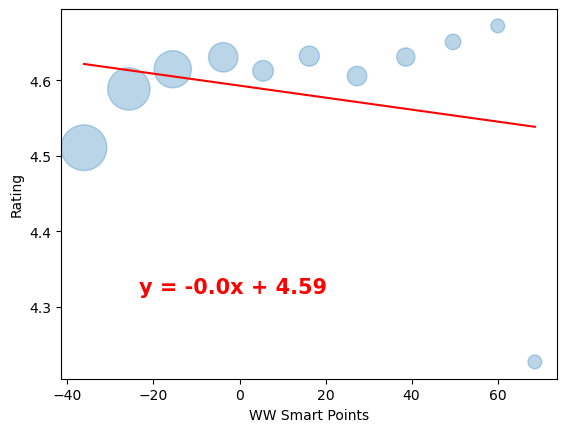

12
The r-value is: 0.12423388010485081


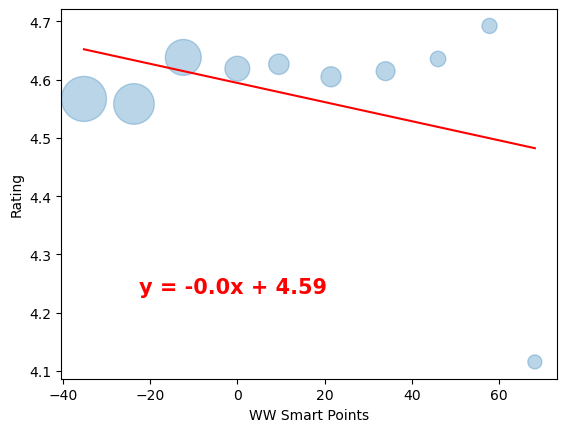

13
The r-value is: 0.17225440505228656


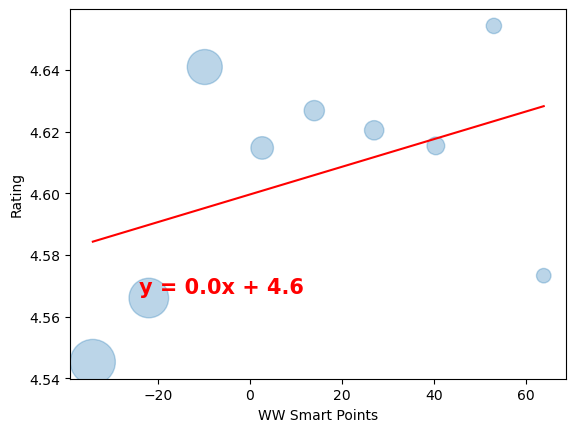

14
The r-value is: 0.0240105163804173


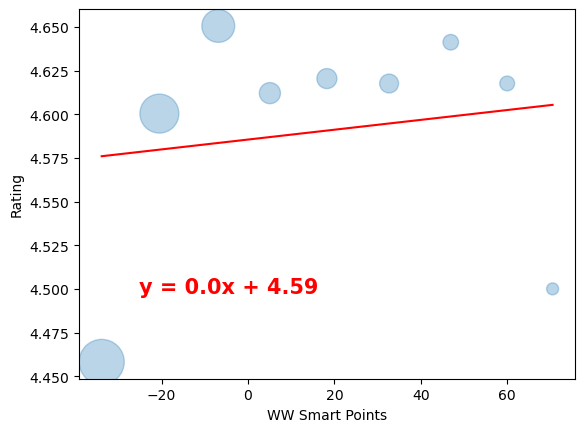

15
The r-value is: 0.043258064787464356


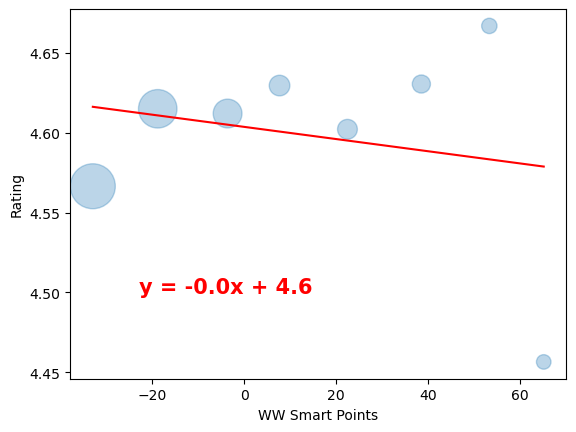

16
The r-value is: 0.004781255362824776


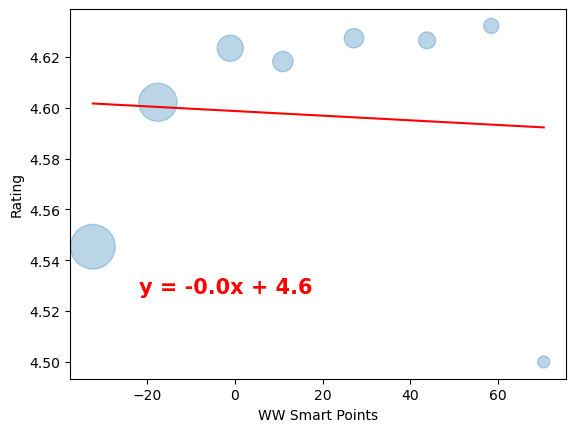

17
The r-value is: 0.11099189089792186


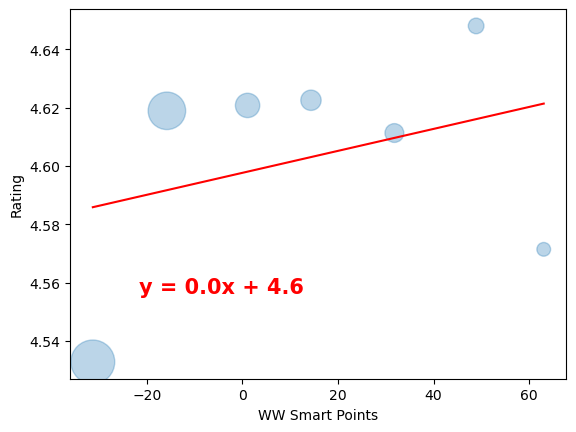

18
The r-value is: 0.17423569684342236


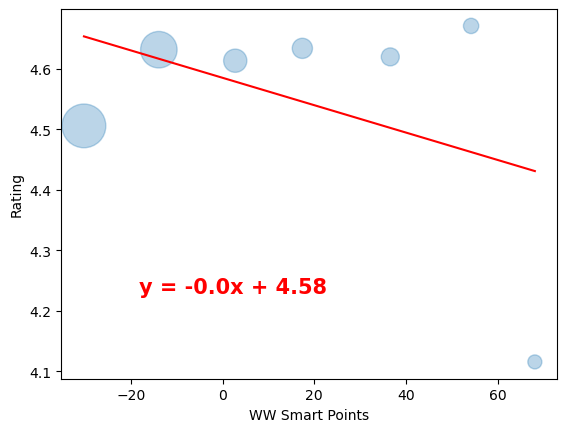

19
The r-value is: 0.24402372396476377


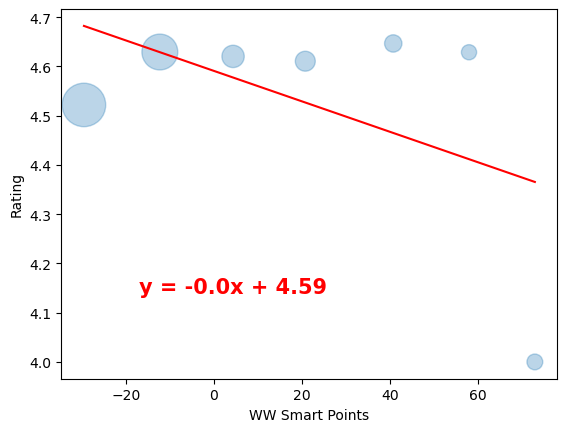

20
The r-value is: 0.41639239010191453


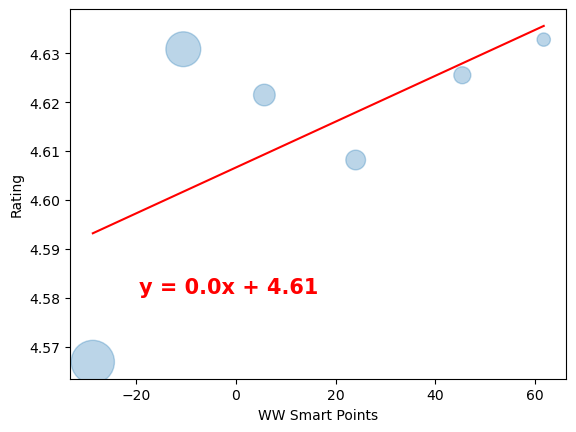

21
The r-value is: 0.2158157644632717


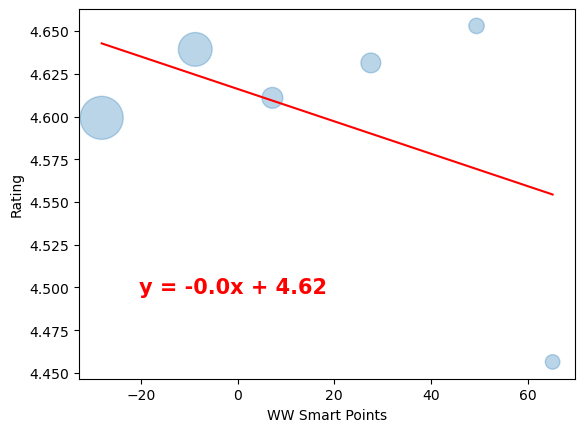

22
The r-value is: 0.2790656333259209


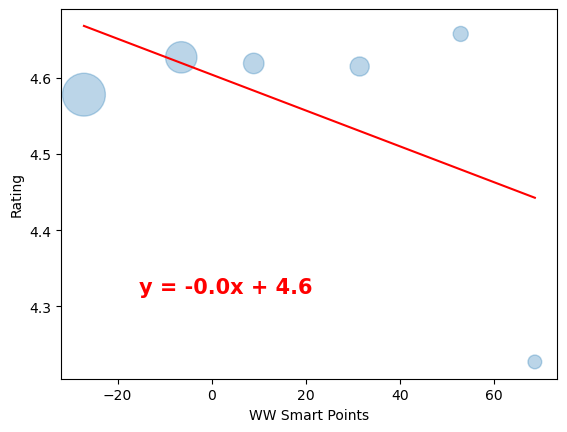

23
The r-value is: 0.29899149860147956


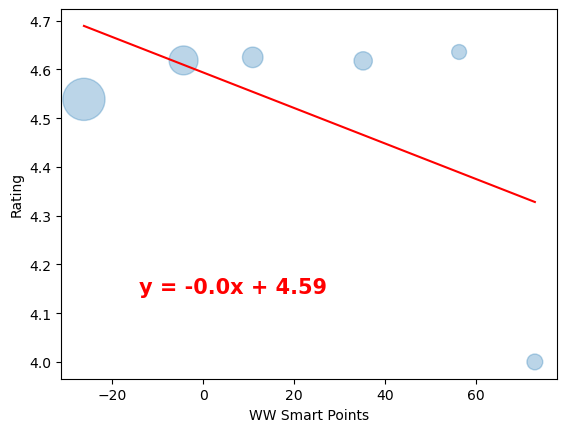

24
The r-value is: 0.5604226758797286


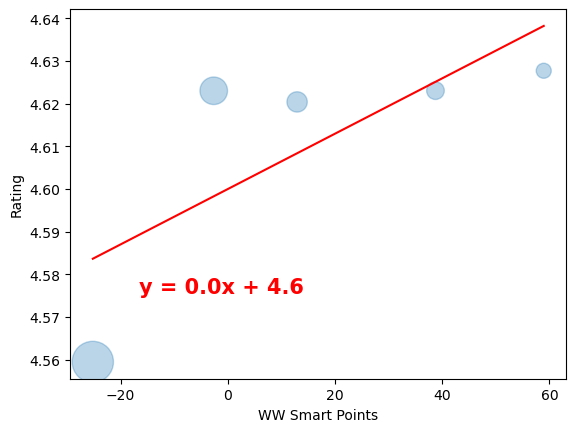

25
The r-value is: 0.6611976351211243


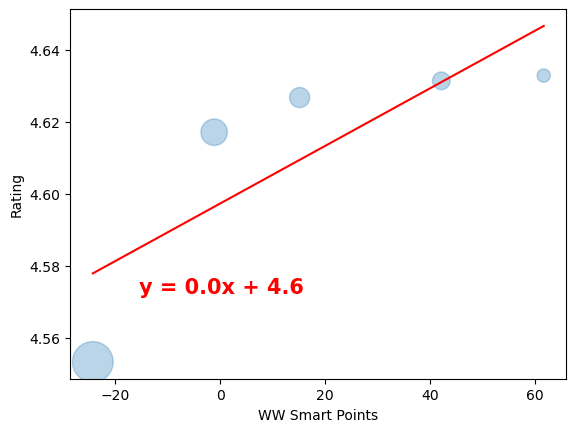

26
The r-value is: 0.02453000489739831


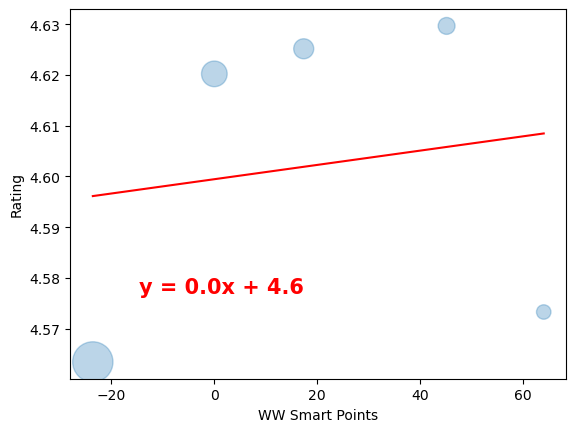

27
The r-value is: 0.38421610031125025


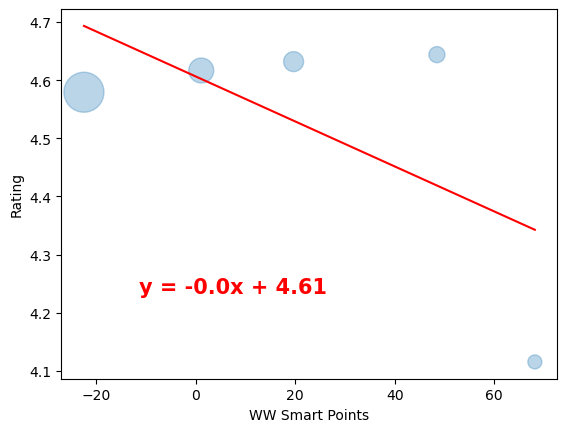

28
The r-value is: 0.19403850906371492


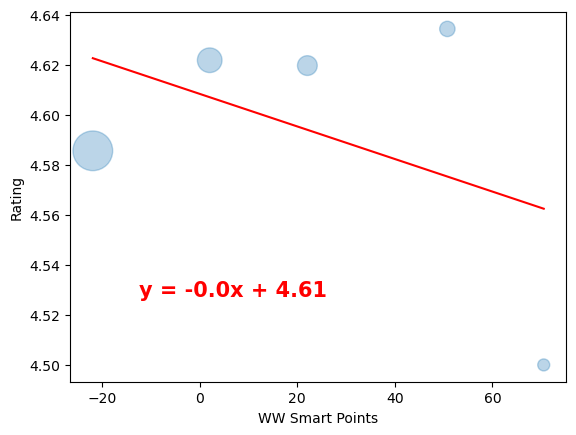

29
The r-value is: 0.4320542218527976


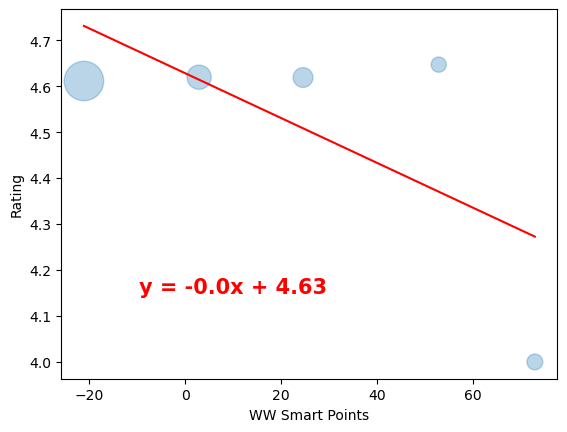

In [62]:
# Bin by `wws_points` then groupby each meal type
min_points = clean_recipes['wws_points'].describe().min()
max_points = clean_recipes['wws_points'].describe().max()

# Create bins
for num in range(1,30):
    points_bins = np.arange(min_points, max_points, num) # CHANGE BETWEEN 10 and 16, and look at PLOT!
    print(num)
    bins_df = pd.cut(clean_recipes['wws_points'], bins=points_bins)
    
    # Set the index and its name
    points_df = clean_recipes.set_index(bins_df)
    points_df.index.name = "WWS Point Ranges"
    
    # Create grouped DataFrame by numeric means
    binned_df = points_df.groupby(['WWS Point Ranges']).mean(numeric_only=True) # originally mean
    # display(binned_df)
    
    # Set the x- and y-values for the plot
    x_val = binned_df['wws_points']
    y_val = binned_df['rating']
    
    fig, ax = plt.subplots()
    ax.scatter(x_val, y_val, s=binned_df['protein_g']*20, alpha=0.3)
    ax.set_xlabel("WW Smart Points")
    ax.set_ylabel("Rating")
    # ax.plot(x_val, y_val)
    linreg_plot(ax, x_val, y_val, 100, 100)

### 5-Star Ratings

In [63]:
# Get the DataFrame for 5-star ratings
top_rated = clean_recipes.loc[clean_recipes['rating'] >= 5].copy()
print(f'top_rated: {top_rated.shape}')

top_rated: (2381, 29)


In [64]:
# Get the DataFrame for all other ratings
bottom_rated = clean_recipes.loc[clean_recipes['rating'] < 5].copy()
print(f'bottom_rated: {bottom_rated.shape}')

bottom_rated: (2665, 29)


The r-value is: 0.7779588740964138


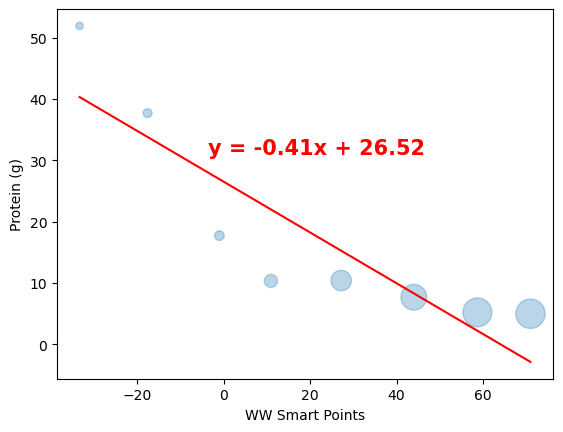

In [65]:
# Bin by `wws_points` then groupby each meal type
min_points = bottom_rated['wws_points'].describe().min()
max_points = bottom_rated['wws_points'].describe().max()

# Create bins
points_bins = np.arange(min_points, max_points, 16) # CHANGE BETWEEN 10 and 16, and look at PLOT!
bins_df = pd.cut(bottom_rated['wws_points'], bins=points_bins)

# Set the index and its name
points_df = bottom_rated.set_index(bins_df)
points_df.index.name = "WWS Point Ranges"

# Create grouped DataFrame by numeric means
binned_df = points_df.groupby(['WWS Point Ranges']).mean(numeric_only=True) # originally mean
binned_df

x_val = binned_df['wws_points']
y_val = binned_df['protein_g']
fig, ax = plt.subplots()
ax.scatter(x_val, y_val, s=binned_df['sugar_g']*10, alpha=0.3)
ax.set_xlabel("WW Smart Points")
ax.set_ylabel("Protein (g)")
# ax.plot(x_val, y_val)
linreg_plot(ax, x_val, y_val, 150, 200)

The r-value is: 0.7923108360966468


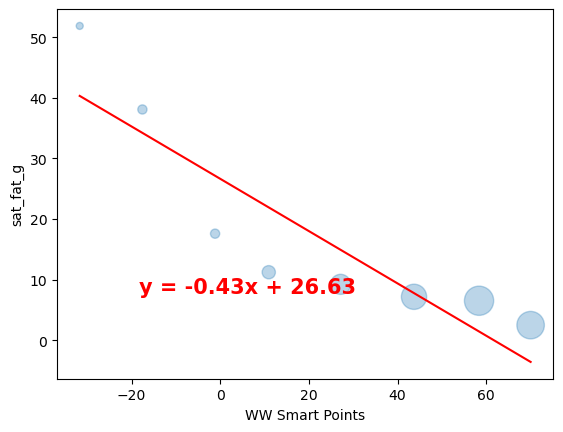

In [66]:
# Bin by `wws_points` then groupby each meal type
min_points = top_rated['wws_points'].describe().min()
max_points = top_rated['wws_points'].describe().max()

# Create bins
points_bins = np.arange(min_points, max_points, 16) # CHANGE BETWEEN 10 and 16, and look at PLOT!
bins_df = pd.cut(top_rated['wws_points'], bins=points_bins)

# Set the index and its name
points_df = top_rated.set_index(bins_df)
points_df.index.name = "WWS Point Ranges"

# Create grouped DataFrame by numeric means
binned_df = points_df.groupby(['WWS Point Ranges']).mean(numeric_only=True) # originally mean
binned_df


x_val = binned_df['wws_points']
y_val = binned_df['protein_g']
fig, ax = plt.subplots()
ax.scatter(x_val, y_val, s=binned_df['sugar_g']*10, alpha=0.3)
ax.set_xlabel("WW Smart Points")
ax.set_ylabel("sat_fat_g")
# ax.plot(x_val, y_val)
linreg_plot(ax, x_val, y_val, 100, 100)

### Lowest WW Smart Points

In [67]:
low_points = clean_recipes.loc[clean_recipes['wws_points'] < -30].copy()
low_points.describe()
low_points.shape

(24, 29)

The r-value is: 5.970140831239508e-07


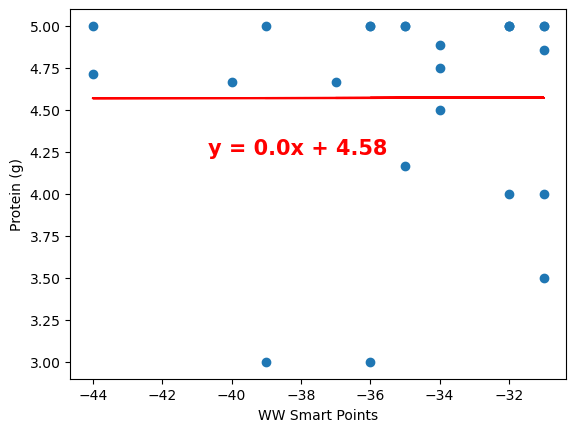

In [68]:
# Bin by `wws_points` then groupby each meal type
min_points = low_points['wws_points'].describe().min()
max_points = low_points['wws_points'].describe().max()

x_val = low_points['wws_points']
y_val = low_points['rating']
fig, ax = plt.subplots()
ax.scatter(x_val, y_val)
ax.set_xlabel("WW Smart Points")
ax.set_ylabel("Protein (g)")
# ax.plot(x_val, y_val)
linreg_plot(ax, x_val, y_val, 150, 200)

In [69]:
low_points['id']

33137      55750
34184     275959
37823     234916
45636      32333
56576      87880
69516     322215
78163     133946
81525     155973
82514     220950
82556      95123
88176     175916
91835     348251
94711     175498
98896     424936
121438    501580
136339    502904
162649    278695
162735     99717
199385    113365
201208    221057
207489    169214
212935    130322
217892    477886
224636    370967
Name: id, dtype: int64

In [70]:
low_points

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
33137,cajun style grilled swordfish,55750,20,57505,2003-03-06,"['30-minutes-or-less', 'time-to-make', 'course...","[477.1, 39.0, 0.0, 9.0, 112.0, 28.0, 0.0]",5,"['prepare a medium-hot grill', 'brush the stea...",swordfish steaks at 10oz are about 1 inch thic...,...,112.0,28.0,0.0,25.35,0.0,0.216,56.0,5.6,0.0,-39
34184,canned tuna donburi,275959,17,665035,2008-01-03,"['30-minutes-or-less', 'time-to-make', 'course...","[571.4, 17.0, 5.0, 31.0, 114.0, 15.0, 18.0]",5,"['add oil to frying pan on medium-high heat', ...",this is a variation of other donburi recipes w...,...,114.0,15.0,18.0,11.05,2.5,0.744,57.0,3.0,54.0,-35
37823,charred prawns shrimp with capsicum mayonnaise,234916,40,68960,2007-06-14,"['60-minutes-or-less', 'time-to-make', 'course...","[393.4, 22.0, 9.0, 21.0, 103.0, 11.0, 4.0]",14,"['peel and devein the prawns , leaving the tai...",red bell pepper is called capsicum in australi...,...,103.0,11.0,4.0,14.30,4.5,0.504,51.5,2.2,12.0,-32
45636,chicken with shrimp scampi,32333,25,27643,2002-06-26,"['30-minutes-or-less', 'time-to-make', 'course...","[484.7, 29.0, 4.0, 44.0, 117.0, 52.0, 5.0]",10,"['coat chicken with mixture of flour , salt , ...",this dinner is a double delight. the chicken a...,...,117.0,52.0,5.0,18.85,2.0,1.056,58.5,10.4,15.0,-37
56576,copycat taco bell chicken enchilada bowl,87880,30,115178,2004-03-31,"['30-minutes-or-less', 'time-to-make', 'course...","[803.1, 42.0, 2.0, 44.0, 124.0, 65.0, 24.0]",9,['lightly season and cube chicken and cook in ...,i love to order this when going to taco bell. ...,...,124.0,65.0,24.0,27.30,1.0,1.056,62.0,13.0,72.0,-31
69516,delicious mexi baked fish fillets,322215,30,89831,2008-08-29,"['30-minutes-or-less', 'time-to-make', 'course...","[376.8, 18.0, 14.0, 39.0, 118.0, 33.0, 1.0]",10,"['set oven to 400 degrees f', 'grease a baking...",the amounts are only a guideline you may adjus...,...,118.0,33.0,1.0,11.70,7.0,0.936,59.0,6.6,3.0,-36
78163,egyptian red snapper in red pepper mint sauce,133946,20,183964,2005-08-18,"['30-minutes-or-less', 'time-to-make', 'course...","[328.6, 9.0, 7.0, 5.0, 120.0, 5.0, 1.0]",4,"['saute onion in olive oil until golden', 'add...",this recipe is posted for the zaar world tour ...,...,120.0,5.0,1.0,5.85,3.5,0.120,60.0,1.0,3.0,-44
81525,feta topped chicken,155973,18,74652,2006-02-13,"['30-minutes-or-less', 'time-to-make', 'course...","[310.4, 9.0, 9.0, 13.0, 114.0, 15.0, 1.0]",7,"['set oven to broil', 'brush both sides of chi...",these are elegant and easy to make. perfect f...,...,114.0,15.0,1.0,5.85,4.5,0.312,57.0,3.0,3.0,-40
82514,fish fillets with harissa and black olives tu...,220950,30,62562,2007-04-05,"['30-minutes-or-less', 'time-to-make', 'course...","[303.3, 8.0, 14.0, 31.0, 106.0, 4.0, 2.0]",10,"['season fish with salt and pepper', 'dust wit...",a delicious way to serve halibut or other firm...,...,106.0,4.0,2.0,5.20,7.0,0.744,53.0,0.8,6.0,-34
82556,fish kibbeh,95123,70,6357,2004-07-06,"['time-to-make', 'course', 'main-ingredient', ...","[242.3, 4.0, 3.0, 5.0, 98.0, 3.0, 0.0]",7,"['in a large bowl , mash the fish along with t...",this is from anjali vellody's food column of t...,...,98.0,3.0,0.0,2.60,1.5,0.120,49.0,0.6,0.0,-39


The r-value is: 0.22054325339120143


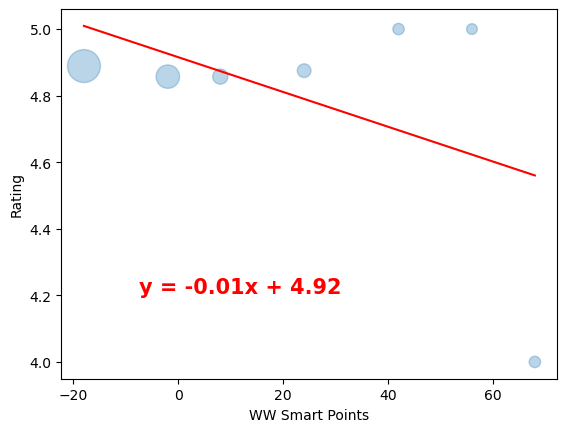

In [71]:
# Remove outliers?
clean_recipes1 = clean_recipes.loc[~clean_recipes['id'].isin(low_points['id'])]

# Bin by `wws_points` then groupby each meal type
min_points = clean_recipes1['wws_points'].describe().min()
max_points = clean_recipes1['wws_points'].describe().max()

# Create bins
points_bins = np.arange(min_points, max_points, 16) # CHANGE BETWEEN 10 and 16, and look at PLOT!
bins_df = pd.cut(clean_recipes1['wws_points'], bins=points_bins)

# Set the index and its name
points_df = clean_recipes1.set_index(bins_df)
points_df.index.name = "WWS Point Ranges"

# Create grouped DataFrame by numeric means
binned_df = points_df.groupby(['WWS Point Ranges']).median(numeric_only=True) # originally mean
binned_df

x_val = binned_df['wws_points']
y_val = binned_df['rating']
fig, ax = plt.subplots()
ax.scatter(x_val, y_val, s=binned_df['protein_g']*15, alpha=0.3)
ax.set_xlabel("WW Smart Points")
ax.set_ylabel("Rating")
# ax.plot(x_val, y_val)
linreg_plot(ax, x_val, y_val, 100, 100)

# Data Exploration - Spoonacular API

## API Testing

### Complex Search and Recipe Information
- Complex Search: [https://spoonacular.com/food-api/docs#Search-Recipes-Complex](https://spoonacular.com/food-api/docs#Search-Recipes-Complex)
- Recipe Information: [https://spoonacular.com/food-api/docs#Get-Recipe-Information](https://spoonacular.com/food-api/docs#Get-Recipe-Information)

__OBSERVATIONS__
- `Complex Search` returns the same result every time, need to try `Random Recipes`.

In [72]:
# Uncomment below to run [API REQUEST - Complex Search]
# complex_search()

# Import and display complex search results
recipes_df = pd.read_csv(f'Resources/01_recipe_IDs/initial_recipes_0.csv')
print(f'recipes_df: {recipes_df.shape}')
recipes_df.head()

# Uncomment below to run [API REQUEST - Recipe Information]
# recipe_info('Resources/02_raw_data/info_master_0.csv')

# Uncomment below to run [API ACTIVE - Check Response]
# check_response()

recipes_df: (100, 4)


,id,title,image,imageType
0,782585,Cannellini Bean and Asparagus Salad with Mushr...,https://spoonacular.com/recipeImages/782585-31...,jpg
1,716426,"Cauliflower, Brown Rice, and Vegetable Fried Rice",https://spoonacular.com/recipeImages/716426-31...,jpg
2,715497,Berry Banana Breakfast Smoothie,https://spoonacular.com/recipeImages/715497-31...,jpg
3,715415,Red Lentil Soup with Chicken and Turnips,https://spoonacular.com/recipeImages/715415-31...,jpg
4,716406,Asparagus and Pea Soup: Real Convenience Food,https://spoonacular.com/recipeImages/716406-31...,jpg


In [73]:
# Import and display recipe information results
info_df = pd.read_csv(f'Resources/02_raw_data/info_master_0.csv')

# Display the DataFrame and its columns
print(info_df.columns)
info_df.head()

Index(['Unnamed: 0', 'vegetarian', 'vegan', 'glutenFree', 'dairyFree',
       'veryHealthy', 'cheap', 'veryPopular', 'sustainable', 'lowFodmap',
       'weightWatcherSmartPoints', 'gaps', 'preparationMinutes',
       'cookingMinutes', 'aggregateLikes', 'healthScore', 'creditsText',
       'sourceName', 'pricePerServing', 'extendedIngredients', 'id', 'title',
       'readyInMinutes', 'servings', 'sourceUrl', 'image', 'imageType',
       'nutrition', 'summary', 'cuisines', 'dishTypes', 'diets', 'occasions',
       'winePairing', 'instructions', 'analyzedInstructions', 'originalId',
       'spoonacularSourceUrl', 'license', 'author'],
      dtype='object')


,Unnamed: 0,vegetarian,vegan,glutenFree,dairyFree,veryHealthy,cheap,veryPopular,sustainable,lowFodmap,...,dishTypes,diets,occasions,winePairing,instructions,analyzedInstructions,originalId,spoonacularSourceUrl,license,author
0,0,True,True,True,True,True,False,False,False,False,...,"['side dish', 'lunch', 'main course', 'salad',...","['gluten free', 'dairy free', 'lacto ovo veget...",[],"{'pairedWines': ['chardonnay', 'sauvignon blan...",Rinse the cannellini beans and soak for 8 hour...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/cannellini-bean-and-as...,NaN,NaN
1,1,True,True,True,True,True,False,True,False,False,...,"['side dish', 'antipasti', 'starter', 'snack',...","['gluten free', 'dairy free', 'lacto ovo veget...",[],"{'pairedWines': ['wine', 'alcoholic drink', 'w...",<ol><li><span></span>Remove the cauliflower's ...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/cauliflower-brown-rice...,CC BY-SA 3.0,NaN
2,2,True,False,False,False,True,False,True,False,False,...,"['morning meal', 'brunch', 'beverage', 'breakf...",['lacto ovo vegetarian'],[],"{'pairedWines': [], 'pairingText': '', 'produc...",<p>Take some yogurt in your favorite flavor an...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/berry-banana-breakfast...,NaN,NaN
3,3,False,False,True,True,True,False,True,False,False,...,"['lunch', 'soup', 'main course', 'main dish', ...","['gluten free', 'dairy free']","['fall', 'winter']","{'pairedWines': [], 'pairingText': '', 'produc...","To a large dutch oven or soup pot, heat the ol...","[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/red-lentil-soup-with-c...,NaN,NaN
4,4,True,True,True,True,True,False,False,False,False,...,"['antipasti', 'soup', 'starter', 'snack', 'app...","['gluten free', 'dairy free', 'paleolithic', '...","['fall', 'winter']","{'pairedWines': ['sparkling wine', 'sparkling ...",<ol><li><span></span>Chop the garlic and onion...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/asparagus-and-pea-soup...,CC BY-SA 3.0,NaN


In [74]:
# Parse the API response - all relevant columns, and account for different units

# Uncomment below to run [API ACTIVE - Parse Response]
# parse_response('Resources/03_simplified_data/initial_nutrition_0.csv')

# Import and display recipe information results
simple_df = pd.read_csv(f'Resources/03_simplified_data/initial_nutrition_0.csv')

# Display the DataFrame and its columns
print(simple_df.columns)
simple_df.head()

Index(['ID', 'Name', 'Likes', 'Meal Type', 'Cuisines', 'N_ingredients',
       'WW Smart Points', 'Calories (Amount)', 'Calories (Unit)',
       'Calories (% of Daily Needs)', 'Saturated Fat (Amount)',
       'Saturated Fat (Unit)', 'Saturated Fat (% of Daily Needs)',
       'Sugar (Amount)', 'Sugar (Unit)', 'Sugar (% of Daily Needs)',
       'Sodium (Amount)', 'Sodium (Unit)', 'Sodium (% of Daily Needs)',
       'Protein (Amount)', 'Protein (Unit)', 'Protein (% of Daily Needs)'],
      dtype='object')


,ID,Name,Likes,Meal Type,Cuisines,N_ingredients,WW Smart Points,Calories (Amount),Calories (Unit),Calories (% of Daily Needs),...,Saturated Fat (% of Daily Needs),Sugar (Amount),Sugar (Unit),Sugar (% of Daily Needs),Sodium (Amount),Sodium (Unit),Sodium (% of Daily Needs),Protein (Amount),Protein (Unit),Protein (% of Daily Needs)
0,782585,Cannellini Bean and Asparagus Salad with Mushr...,309,"['side dish', 'lunch', 'main course', 'salad',...",[],13,12,488.93,kcal,24.45,...,6.49,4.29,g,4.76,421.70,mg,18.33,32.02,g,64.03
1,716426,"Cauliflower, Brown Rice, and Vegetable Fried Rice",3689,"['side dish', 'antipasti', 'starter', 'snack',...","['Chinese', 'Asian']",15,4,220.82,kcal,11.04,...,6.99,5.29,g,5.87,445.90,mg,19.39,9.03,g,18.05
2,715497,Berry Banana Breakfast Smoothie,689,"['morning meal', 'brunch', 'beverage', 'breakf...",[],5,15,457.05,kcal,22.85,...,16.88,52.28,g,58.09,400.90,mg,17.43,20.62,g,41.25
3,715415,Red Lentil Soup with Chicken and Turnips,1866,"['lunch', 'soup', 'main course', 'main dish', ...",[],13,11,477.24,kcal,23.86,...,19.37,10.55,g,11.72,1335.78,mg,58.08,26.93,g,53.86
4,716406,Asparagus and Pea Soup: Real Convenience Food,207,"['antipasti', 'soup', 'starter', 'snack', 'app...",[],8,2,452.33,kcal,22.62,...,8.34,27.99,g,31.10,25.76,mg,1.12,26.56,g,53.12


In [75]:
# Check the units columns
units_columns = ['Calories (Unit)', 'Saturated Fat (Unit)', 'Sugar (Unit)', 'Sodium (Unit)', 'Protein (Unit)']
for col in units_columns:
    check = simple_df[col].unique()
    print(f"Unit check: {col} {check}")

# Account for the differences when calculating points

Unit check: Calories (Unit) ['kcal']
Unit check: Saturated Fat (Unit) ['g']
Unit check: Sugar (Unit) ['g']
Unit check: Sodium (Unit) ['mg']
Unit check: Protein (Unit) ['g' 'mg']


### Random Recipes and Recipe Information
- Random Recipes: [https://spoonacular.com/food-api/docs#Get-Random-Recipes](https://spoonacular.com/food-api/docs#Get-Random-Recipes)
- Recipe Information: [https://spoonacular.com/food-api/docs#Get-Recipe-Information](https://spoonacular.com/food-api/docs#Get-Recipe-Information)

__OBSERVATIONS__
- Once converted to a dataframe, the data is not as accessible as navigating the API response, will need to create a simplified dataframe while the API response is available.
- Although this has metadata, it still does not have `Nutrition` information, will still need to run the `Recipe Information` request. Need to identify a cost-effective API request methodology.

In [76]:
# Uncomment below to run [API REQUEST - Random Recipe]
# random_recipe('Resources/01_recipe_IDs/initial_recipes_4.csv')

# Import and display random recipes results
random_df = pd.read_csv(f'Resources/01_recipe_IDs/initial_recipes_4.csv')
random_df.head()

,vegetarian,vegan,glutenFree,dairyFree,veryHealthy,cheap,veryPopular,sustainable,lowFodmap,weightWatcherSmartPoints,...,cuisines,dishTypes,diets,occasions,instructions,analyzedInstructions,originalId,spoonacularSourceUrl,license,author
0,False,False,False,False,False,False,False,False,False,28,...,['American'],"['lunch', 'main course', 'main dish', 'dinner']",[],[],<ol><li>Preheat broiler. </li><li>Heat large f...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/tex-mex-burger-663050,NaN,NaN
1,False,False,False,False,False,False,False,False,False,39,...,[],['dessert'],[],[],<ol><li>Preheat oven to 180 degrees C</li><li>...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/chocolate-banoffee-pie...,CC BY 3.0,NaN
2,True,True,True,True,False,False,False,False,False,3,...,[],"['side dish', 'antipasti', 'salad', 'starter',...","['gluten free', 'dairy free', 'paleolithic', '...",['christmas'],Finely grate enough zest from the orange to me...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/fennel-and-orange-sala...,CC BY 3.0,NaN
3,False,False,False,True,False,False,False,False,False,12,...,['Mexican'],"['lunch', 'main course', 'main dish', 'dinner']","['dairy free', 'pescatarian']",[],In pie pan/deep dish add your Italian bread cr...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/kks-fish-tacos-648974,NaN,NaN
4,True,True,True,True,True,False,False,False,False,6,...,[],"['lunch', 'soup', 'main course', 'main dish', ...","['gluten free', 'dairy free', 'lacto ovo veget...","['fall', 'winter']",<ol><li>Rinse the beans thoroughly and place t...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/tuscan-white-bean-soup...,NaN,NaN


In [77]:
# # Uncomment block to run [API REQUEST - Recipe Information]
# recipe_info('Resources/02_raw_data/info_master_4.csv')

# # Uncomment block to run [API ACTIVE - Parse Response]
# parse_response('Resources/03_simplified_data/initial_nutrition_4.csv')

### Random Recipes and Nutrition by ID

In [78]:
# # Uncomment block to run [API REQUEST - Random Recipe and Nutrition by ID]
# recipe_info('Resources/02_raw_data/info_master_5.csv')

# # Uncomment block to run [API REQUEST - Nutrition by ID]
# nutrition_id('Resources/02_raw_data/info_master_5.csv')

# # Uncomment block to parse the response (added carbohydrates)
# parse_metadata(
#     'Resources/01_recipe_IDs/initial_recipes_5.csv',
#     'Resources/03_simplified_data/initial_nutrition_5.csv')

## Spoonacular API Data Collection
__Method 1__

- API request cost comparison:
    * Type 1: `Random Recipes` + `Recipe Information` = 2.1 points per request
    * Type 2: `Random Recipes` + `Nutrition by ID` = 2 points per request

__Method 2__

* `Complex Search` with a more comprehensive params dictionary.
* Identified as the most cost-efficient method, a single request with all the details.

__Method 3__
* `Recipe Information` requests only.
* Used for getting information when Recipe IDs already exist.

In [79]:
# Uncomment the line below to run Method 1
# spoonacular_v1(type=2)

# Uncomment the line below to run Method 2
# spoonacular_v2()

## Get Recipe IDs from Raw Data

In [80]:
# Get list of subdirectories in the Resources folder
from pathlib import Path
subdir_list = []
for path in Path('Resources').iterdir():
    # Ignore `.ipynb_checkpoints`
    if (path == Path('Resources/.ipynb_checkpoints')):
        continue
    elif path.is_dir():
        subdir_list.append(path)

# Loop over folders without simplified data
raw_ids = []
raw_files = []
for dir in subdir_list[0:2]:
    # Read each file in the directory
    for file in os.scandir(dir):
        # Check if the file is NOT a directory, ignore `.ipynb_checkpoints`
        if os.path.isfile(file) & (file.name != '.ipynb_checkpoints'):
            filename = f'{dir}/{file.name}'
            csv_df = pd.read_csv(filename)
            try:
                raw_ids.append(csv_df['id'])
                raw_files.append(filename)
            except:
                # If no 'id' column, move on to the next csv
                continue

# Get a unique list of recipe IDs
raw_list = [id for row in raw_ids for id in row]
unique_raw = list(set(raw_list))

# Remove NaN values from unique_raw
clean_raw = []
for value in unique_raw:
    try:
        clean_raw.append(int(value))
    except:
        # Value cannot be cast to int
        continue
print(f'Unique out of raw data: {len(clean_raw)} of {len(raw_list)}')

# Loop over folders with simplified data
simple_ids = []
simple_files = []
for dir in subdir_list[2:]:
    # Read each file in the directory
    for file in os.scandir(dir):
        # Check if the file is NOT a directory, ignore `.ipynb_checkpoints`
        if os.path.isfile(file) & (file.name != '.ipynb_checkpoints') & (file.name.split('.')[-1] == 'csv'):
                filename = f'{dir}/{file.name}'
                csv_df = pd.read_csv(filename)
                try:
                    try:
                        simple_ids.append(csv_df['id'])
                    except:
                        simple_ids.append(csv_df['ID'])
                    simple_files.append(filename)
                except:
                    # If no 'id' column, move on to the next csv
                    continue

# Get a unique list of recipe IDs
simple_list = [id for row in simple_ids for id in row]
unique_simple = list(set(simple_list))
print(f'Unique out of simplified data: {len(unique_simple)} of {len(simple_list)}')

# Identify the intersection between the unique raw and unique simplified data
intersect_ids = []
missing_ids = set(clean_raw).difference(set(unique_simple))
if set(clean_raw) & set(unique_simple):
    intersect_ids.append(set(clean_raw) & set(unique_simple))
print(f'Total intersection: {len(intersect_ids[0])}')
print(f'Total missing: {len(missing_ids)}')

Unique out of raw data: 1074 of 2339
Unique out of simplified data: 1074 of 1637
Total intersection: 1074
Total missing: 0


In [81]:
# If there are IDs with missing information, get the data
if len(missing_ids) > 0:
    spoonacular_v3(missing_ids)

### Get Missing Data from another column (Simplified Data)

In [82]:
# Import one file from 03_simplified_data as a reference
simple_ref = pd.read_csv('Resources/03_simplified_data/initial_nutrition_7.csv').columns
simple_ref

Index(['ID', 'Name', 'Likes', 'Meal Type', 'Cuisines', 'N_ingredients',
       'WW Smart Points', 'Calories (Amount)', 'Calories (Unit)',
       'Calories (% of Daily Needs)', 'Saturated Fat (Amount)',
       'Saturated Fat (Unit)', 'Saturated Fat (% of Daily Needs)',
       'Sugar (Amount)', 'Sugar (Unit)', 'Sugar (% of Daily Needs)',
       'Sodium (Amount)', 'Sodium (Unit)', 'Sodium (% of Daily Needs)',
       'Protein (Amount)', 'Protein (Unit)', 'Protein (% of Daily Needs)',
       'Carbohydrates'],
      dtype='object')

In [83]:
# Import one file from 04_complex_test as a reference
complex_ref = pd.read_csv('Resources/04_complex_test/simplified_data_0.csv').columns
complex_ref

Index(['ID', 'Name', 'Likes', 'Meal Type', 'Cuisines', 'N_ingredients',
       'WW Smart Points', 'Cooking Minutes', 'Prep Minutes',
       'Calories (Amount)', 'Calories (Unit)', 'Calories (% of Daily Needs)',
       'Saturated Fat (Amount)', 'Saturated Fat (Unit)',
       'Saturated Fat (% of Daily Needs)', 'Sugar (Amount)', 'Sugar (Unit)',
       'Sugar (% of Daily Needs)', 'Sodium (Amount)', 'Sodium (Unit)',
       'Sodium (% of Daily Needs)', 'Protein (Amount)', 'Protein (Unit)',
       'Protein (% of Daily Needs)', 'Carbs (Amount)', 'Carbs (Unit)',
       'Carbs (% of Daily Needs)'],
      dtype='object')

In [84]:
# Read each simplified data file and create a DataFrame
df_list = []
for file in simple_files:
    one_df = pd.read_csv(file)
    df_list.append(one_df)
simplified_df = pd.concat(df_list, ignore_index=True)

# Identify duplicate IDs
duplicate_IDs = simplified_df.loc[simplified_df.duplicated(['ID'])]
print(f'Number of duplicate rows to remove: {duplicate_IDs.shape[0]}')

# Create a new DataFrame without the duplicates
simplified_df = simplified_df.loc[~simplified_df.duplicated(['ID'])].copy()

# Display the DataFrame, columns, and shape
print(f'simplified_df: {simplified_df.shape}')
print(simplified_df.columns)
simplified_df.head()

Number of duplicate rows to remove: 563
simplified_df: (1074, 28)
Index(['ID', 'Name', 'Likes', 'Meal Type', 'Cuisines', 'N_ingredients',
       'WW Smart Points', 'Calories (Amount)', 'Calories (Unit)',
       'Calories (% of Daily Needs)', 'Saturated Fat (Amount)',
       'Saturated Fat (Unit)', 'Saturated Fat (% of Daily Needs)',
       'Sugar (Amount)', 'Sugar (Unit)', 'Sugar (% of Daily Needs)',
       'Sodium (Amount)', 'Sodium (Unit)', 'Sodium (% of Daily Needs)',
       'Protein (Amount)', 'Protein (Unit)', 'Protein (% of Daily Needs)',
       'Carbohydrates', 'Cooking Minutes', 'Prep Minutes', 'Carbs (Amount)',
       'Carbs (Unit)', 'Carbs (% of Daily Needs)'],
      dtype='object')


,ID,Name,Likes,Meal Type,Cuisines,N_ingredients,WW Smart Points,Calories (Amount),Calories (Unit),Calories (% of Daily Needs),...,Sodium (% of Daily Needs),Protein (Amount),Protein (Unit),Protein (% of Daily Needs),Carbohydrates,Cooking Minutes,Prep Minutes,Carbs (Amount),Carbs (Unit),Carbs (% of Daily Needs)
0,664101,Turkish squares,3,['side dish'],[],11,25.0,603.77,kcal,30.19,...,14.43,12.59,g,25.17,87g,NaN,NaN,NaN,NaN,NaN
1,636732,Cajun Lobster Pasta,2,"['side dish', 'lunch', 'main course', 'main di...","['Creole', 'Cajun']",17,22.0,734.22,kcal,36.71,...,99.96,36.92,g,73.84,39g,NaN,NaN,NaN,NaN,NaN
2,633078,Authentic Italian Biscotti,24,['dessert'],"['Mediterranean', 'Italian', 'European']",8,2.0,54.31,kcal,2.72,...,2.70,1.37,g,2.75,8g,NaN,NaN,NaN,NaN,NaN
3,632075,All Day Simple Slow-Cooker FALL OFF the BONE Ribs,61,"['antipasti', 'starter', 'snack', 'appetizer',...",[],4,29.0,614.38,kcal,30.72,...,128.53,9.57,g,19.14,117g,NaN,NaN,NaN,NaN,NaN
4,715562,Loaded Baked Potato Soup,5743,"['lunch', 'soup', 'main course', 'main dish', ...",[],9,24.0,623.73,kcal,31.19,...,26.09,21.16,g,42.32,58g,NaN,NaN,NaN,NaN,NaN


In [85]:
# Read each raw data file and create a DataFrame
df_list = []
for file in raw_files:
    one_df = pd.read_csv(file)
    df_list.append(one_df)
raw_df = pd.concat(df_list, ignore_index=True)

# Drop rows with missing IDs
raw_df = raw_df.loc[~raw_df['id'].isna()]

# Reduce DataFrame to unique IDs
raw_df = raw_df.loc[~raw_df.duplicated(['id'])].copy()

# Display the DataFrame, columns, and shape
print(f'raw_df: {raw_df.shape}')
print(raw_df.columns)
raw_df.head()

raw_df: (1074, 43)
Index(['vegetarian', 'vegan', 'glutenFree', 'dairyFree', 'veryHealthy',
       'cheap', 'veryPopular', 'sustainable', 'lowFodmap',
       'weightWatcherSmartPoints', 'gaps', 'preparationMinutes',
       'cookingMinutes', 'aggregateLikes', 'healthScore', 'creditsText',
       'sourceName', 'pricePerServing', 'extendedIngredients', 'id', 'title',
       'readyInMinutes', 'servings', 'sourceUrl', 'image', 'imageType',
       'nutrition', 'summary', 'cuisines', 'dishTypes', 'diets', 'occasions',
       'winePairing', 'instructions', 'analyzedInstructions', 'originalId',
       'spoonacularSourceUrl', 'author', 'license', 'status', 'code',
       'message', 'Unnamed: 0'],
      dtype='object')


,vegetarian,vegan,glutenFree,dairyFree,veryHealthy,cheap,veryPopular,sustainable,lowFodmap,weightWatcherSmartPoints,...,instructions,analyzedInstructions,originalId,spoonacularSourceUrl,author,license,status,code,message,Unnamed: 0
0,False,False,False,False,False,False,False,False,False,31.0,...,"<ol><li>While potatoes are frying, heat vegeta...","[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/best-breakfast-burrito...,NaN,NaN,NaN,NaN,NaN,NaN
1,False,False,True,False,False,False,False,False,False,19.0,...,"<p>1. Pre-heat oven to ~450°F (230°C), top hea...","[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/pittata-pizza-frittata...,coffeebean,NaN,NaN,NaN,NaN,NaN
2,True,True,True,True,True,False,False,False,False,8.0,...,Saut onion and garlic in olive oil for 5 minut...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/tomato-and-lentil-soup...,NaN,NaN,NaN,NaN,NaN,NaN
3,True,False,False,False,False,False,False,False,False,8.0,...,<ol><li>Preheat oven to 375F with the rack in ...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/savory-cheese-dill-sco...,NaN,CC BY 3.0,NaN,NaN,NaN,NaN
4,False,False,True,True,False,False,False,False,False,5.0,...,<ol><li><span></span>Heat a skillet over mediu...,"[{'name': '', 'steps': [{'number': 1, 'step': ...",NaN,https://spoonacular.com/garlic-lemon-pepper-sh...,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
# Minimum columns required
min_cols = ['ID', 'Name', 'Likes', 'Meal Type', 'Cuisines', 'N_ingredients',
       'WW Smart Points', 'Cooking Minutes', 'Calories (Amount)', 'Calories (Unit)',
        'Calories (% of Daily Needs)', 'Saturated Fat (Amount)', 'Saturated Fat (Unit)',
       'Saturated Fat (% of Daily Needs)', 'Sugar (Amount)', 'Sugar (Unit)',
       'Sugar (% of Daily Needs)', 'Sodium (Amount)', 'Sodium (Unit)',
       'Sodium (% of Daily Needs)', 'Protein (Amount)', 'Protein (Unit)',
       'Protein (% of Daily Needs)', 'Carbs (Amount)', 'Carbs (Unit)',
       'Carbs (% of Daily Needs)']

# Identify columns with missing data
missing_cols = []
for col in min_cols:
    check_na = simplified_df.loc[simplified_df[col].isna()]
    num_na = len(check_na)
    if (num_na > 0):
        missing_cols.append(col)
    print(f'{col}: {num_na}')
print(f'\nColumns with null values: {missing_cols}')

ID: 0
Name: 0
Likes: 0
Meal Type: 0
Cuisines: 0
N_ingredients: 0
WW Smart Points: 0
Cooking Minutes: 601
Calories (Amount): 0
Calories (Unit): 0
Calories (% of Daily Needs): 0
Saturated Fat (Amount): 0
Saturated Fat (Unit): 0
Saturated Fat (% of Daily Needs): 0
Sugar (Amount): 0
Sugar (Unit): 0
Sugar (% of Daily Needs): 0
Sodium (Amount): 0
Sodium (Unit): 0
Sodium (% of Daily Needs): 0
Protein (Amount): 0
Protein (Unit): 0
Protein (% of Daily Needs): 0
Carbs (Amount): 601
Carbs (Unit): 601
Carbs (% of Daily Needs): 601

Columns with null values: ['Cooking Minutes', 'Carbs (Amount)', 'Carbs (Unit)', 'Carbs (% of Daily Needs)']


### Get Missing Data from elsewhere (Raw Data)

In [87]:
# Get the list of recipe IDs with missing data
missing_recipes = check_na['ID']

# Check if the missing data have rows in raw_df
find_missing = raw_df.loc[raw_df['id'].isin(missing_recipes)]

# Check if there is a nutrition column for the missing data
find_nutrition = raw_df.loc[~raw_df['nutrition'].isna()]
print(f'Missing recipes in raw_df with a nutrition column: {len(find_nutrition)}')

Missing recipes in raw_df with a nutrition column: 886


In [88]:
# Test get_nutrition() function
test_nutrition = get_nutrition(raw_df['nutrition'][0], 'Carbohydrates')
test_nutrition

[98.02, 'g', 32.67]

In [89]:
# Populate simplified_df with the missing data
for df_idx, row in find_nutrition.iterrows():
    result = get_nutrition(row['nutrition'], 'Carbohydrates')
    recipe_id = find_nutrition.loc[df_idx, 'id']
    simplified_df.loc[simplified_df['ID'] == recipe_id, 'Carbs (Amount)'] = result[0]
    simplified_df.loc[simplified_df['ID'] == recipe_id, 'Carbs (Unit)'] = result[1]
    simplified_df.loc[simplified_df['ID'] == recipe_id, 'Carbs (% of Daily Needs)'] = result[2]

# Identify columns with missing data
missing_cols = []
missing_ids = []
for col in min_cols:
    check_na = simplified_df.loc[simplified_df[col].isna()]
    num_na = len(check_na)
    if (num_na > 0):
        missing_cols.append(col)
        missing_ids.append(check_na['ID'])
    print(f'{col}: {num_na}')
print(f'\nColumns with null values: {missing_cols}')

# Flatten list of missing IDs
missing_list = [id for id_list in missing_ids for id in id_list]

ID: 0
Name: 0
Likes: 0
Meal Type: 0
Cuisines: 0
N_ingredients: 0
WW Smart Points: 0
Cooking Minutes: 601
Calories (Amount): 0
Calories (Unit): 0
Calories (% of Daily Needs): 0
Saturated Fat (Amount): 0
Saturated Fat (Unit): 0
Saturated Fat (% of Daily Needs): 0
Sugar (Amount): 0
Sugar (Unit): 0
Sugar (% of Daily Needs): 0
Sodium (Amount): 0
Sodium (Unit): 0
Sodium (% of Daily Needs): 0
Protein (Amount): 0
Protein (Unit): 0
Protein (% of Daily Needs): 0
Carbs (Amount): 188
Carbs (Unit): 188
Carbs (% of Daily Needs): 188

Columns with null values: ['Cooking Minutes', 'Carbs (Amount)', 'Carbs (Unit)', 'Carbs (% of Daily Needs)']


In [90]:
# Identify the recipes with still missing values
still_missing = simplified_df.loc[simplified_df['ID'].isin(missing_list)]
check_column = still_missing.loc[still_missing['Carbohydrates'].isna()]

# Display the DataFrame
print(f'Carbohydrates column with missing values: {len(check_column)}')
still_missing.head() # Data is in 'Carbohydrates' column

Carbohydrates column with missing values: 256


,ID,Name,Likes,Meal Type,Cuisines,N_ingredients,WW Smart Points,Calories (Amount),Calories (Unit),Calories (% of Daily Needs),...,Sodium (% of Daily Needs),Protein (Amount),Protein (Unit),Protein (% of Daily Needs),Carbohydrates,Cooking Minutes,Prep Minutes,Carbs (Amount),Carbs (Unit),Carbs (% of Daily Needs)
0,664101,Turkish squares,3,['side dish'],[],11,25.0,603.77,kcal,30.19,...,14.43,12.59,g,25.17,87g,NaN,NaN,87.04,g,29.01
1,636732,Cajun Lobster Pasta,2,"['side dish', 'lunch', 'main course', 'main di...","['Creole', 'Cajun']",17,22.0,734.22,kcal,36.71,...,99.96,36.92,g,73.84,39g,NaN,NaN,NaN,NaN,NaN
2,633078,Authentic Italian Biscotti,24,['dessert'],"['Mediterranean', 'Italian', 'European']",8,2.0,54.31,kcal,2.72,...,2.70,1.37,g,2.75,8g,NaN,NaN,8.17,g,2.72
3,632075,All Day Simple Slow-Cooker FALL OFF the BONE Ribs,61,"['antipasti', 'starter', 'snack', 'appetizer',...",[],4,29.0,614.38,kcal,30.72,...,128.53,9.57,g,19.14,117g,NaN,NaN,NaN,NaN,NaN
4,715562,Loaded Baked Potato Soup,5743,"['lunch', 'soup', 'main course', 'main dish', ...",[],9,24.0,623.73,kcal,31.19,...,26.09,21.16,g,42.32,58g,NaN,NaN,NaN,NaN,NaN


In [91]:
# Drop null values from the carbohydrates column
still_missing = still_missing.dropna(subset='Carbohydrates', how="any")

# Add carbohydrates columns
for df_idx, row in still_missing.iterrows():
    carbs = row['Carbohydrates']
    recipe_id = still_missing.loc[df_idx, 'ID']
    # Check if the units are consistent (i.e. no 'mg')
    if "m" in carbs:
        print("Inconsistent units")
    else:
        amount = float(carbs[:-1])
        units = carbs[-1]
        pdv = round(100 * amount / conversion_ref[5], 2)

        simplified_df.loc[simplified_df['ID'] == recipe_id, 'Carbs (Amount)'] = amount
        simplified_df.loc[simplified_df['ID'] == recipe_id, 'Carbs (Unit)'] = units
        simplified_df.loc[simplified_df['ID'] == recipe_id, 'Carbs (% of Daily Needs)'] = pdv

# Identify columns with missing data
missing_cols = []
missing_ids = []
for col in min_cols:
    check_na = simplified_df.loc[simplified_df[col].isna()]
    num_na = len(check_na)
    if (num_na > 0):
        missing_cols.append(col)
        missing_ids.append(check_na['ID'])
    print(f'{col}: {num_na}')
print(f'\nColumns with null values: {missing_cols}')

# Flatten list of missing IDs
missing_list = [id for id_list in missing_ids for id in id_list]

ID: 0
Name: 0
Likes: 0
Meal Type: 0
Cuisines: 0
N_ingredients: 0
WW Smart Points: 0
Cooking Minutes: 601
Calories (Amount): 0
Calories (Unit): 0
Calories (% of Daily Needs): 0
Saturated Fat (Amount): 0
Saturated Fat (Unit): 0
Saturated Fat (% of Daily Needs): 0
Sugar (Amount): 0
Sugar (Unit): 0
Sugar (% of Daily Needs): 0
Sodium (Amount): 0
Sodium (Unit): 0
Sodium (% of Daily Needs): 0
Protein (Amount): 0
Protein (Unit): 0
Protein (% of Daily Needs): 0
Carbs (Amount): 0
Carbs (Unit): 0
Carbs (% of Daily Needs): 0

Columns with null values: ['Cooking Minutes']


In [92]:
# Identify the recipes with still missing values
still_missing = simplified_df.loc[simplified_df['ID'].isin(missing_list)]
check_column = still_missing.loc[still_missing['Cooking Minutes'].isna()]

# Display the DataFrame
print(f'Cooking Minutes column with missing values: {len(check_column)}')
still_missing.head() # Data is in 'readyInMinutes' column

# Drop the 'Prep Minutes' column
simplified_df = simplified_df.drop(columns=['Prep Minutes'])
simplified_df.columns

Cooking Minutes column with missing values: 601


Index(['ID', 'Name', 'Likes', 'Meal Type', 'Cuisines', 'N_ingredients',
       'WW Smart Points', 'Calories (Amount)', 'Calories (Unit)',
       'Calories (% of Daily Needs)', 'Saturated Fat (Amount)',
       'Saturated Fat (Unit)', 'Saturated Fat (% of Daily Needs)',
       'Sugar (Amount)', 'Sugar (Unit)', 'Sugar (% of Daily Needs)',
       'Sodium (Amount)', 'Sodium (Unit)', 'Sodium (% of Daily Needs)',
       'Protein (Amount)', 'Protein (Unit)', 'Protein (% of Daily Needs)',
       'Carbohydrates', 'Cooking Minutes', 'Carbs (Amount)', 'Carbs (Unit)',
       'Carbs (% of Daily Needs)'],
      dtype='object')

In [93]:
# Add cooking minutes column
for df_idx, row in still_missing.iterrows():
    recipe_id = still_missing.loc[df_idx, 'ID']
    mins = raw_df.loc[raw_df['id'] == recipe_id, 'readyInMinutes']
    simplified_df['Cooking Minutes'] = float(mins)

# Identify columns with missing data
missing_cols = []
missing_ids = []
for col in min_cols:
    check_na = simplified_df.loc[simplified_df[col].isna()]
    num_na = len(check_na)
    if (num_na > 0):
        missing_cols.append(col)
        missing_ids.append(check_na['ID'])
    print(f'{col}: {num_na}')
print(f'\nColumns with null values: {missing_cols}')

ID: 0
Name: 0
Likes: 0
Meal Type: 0
Cuisines: 0
N_ingredients: 0
WW Smart Points: 0
Cooking Minutes: 0
Calories (Amount): 0
Calories (Unit): 0
Calories (% of Daily Needs): 0
Saturated Fat (Amount): 0
Saturated Fat (Unit): 0
Saturated Fat (% of Daily Needs): 0
Sugar (Amount): 0
Sugar (Unit): 0
Sugar (% of Daily Needs): 0
Sodium (Amount): 0
Sodium (Unit): 0
Sodium (% of Daily Needs): 0
Protein (Amount): 0
Protein (Unit): 0
Protein (% of Daily Needs): 0
Carbs (Amount): 0
Carbs (Unit): 0
Carbs (% of Daily Needs): 0

Columns with null values: []


## Extract Meal Types

In [94]:
simplified_df['Meal Type']

0                                           ['side dish']
1       ['side dish', 'lunch', 'main course', 'main di...
2                                             ['dessert']
3       ['antipasti', 'starter', 'snack', 'appetizer',...
4       ['lunch', 'soup', 'main course', 'main dish', ...
                              ...                        
1632                                          ['dessert']
1633    ['fingerfood', 'antipasti', 'starter', 'snack'...
1634                                          ['dessert']
1635    ['side dish', 'lunch', 'main course', 'main di...
1636    ['antipasti', 'starter', 'snack', 'appetizer',...
Name: Meal Type, Length: 1074, dtype: object

In [95]:
updated_types
meal_dict = parse_tags(updated_types, 'Meal Type', simplified_df, 'ID')
all_meals = []
for key in meal_dict:
    print(f'{key}: {meal_dict[key]["count"]}')
    if key != "multiple":
        all_meals.append(meal_dict[key]['id_list'])
flat_meals = [id for id_list in all_meals for id in id_list]
unique_meals = set(flat_meals) - set(meal_dict['multiple']['id_list'])
len(unique_meals)

# CONCLUSION: Based on this alone, there is not enough data to continue analysis with Spoonacular.

breakfast: 211
lunch: 439
dinner: 439
multiple: 470


180

## Outlier Identification

### Descriptive Statistics

In [96]:
# Get a list of columns of type int64 and float64, excluding 'id' and 'contributor_id'
calc_cols = simplified_df.select_dtypes(include=['int64', 'float64']).drop(columns=['ID'])

# Calculate IQR and bounds, then display the descriptive statistics
calc_stats = calc_cols.describe().T.drop(columns=['count'])
print(f'Columns with values above "max":{len(add_iqr(calc_stats))}\n{add_iqr(calc_stats)}')
calc_stats = calc_stats.T
calc_stats

Columns with values above "max":15
['Likes', 'N_ingredients', 'WW Smart Points', 'Calories (Amount)', 'Calories (% of Daily Needs)', 'Saturated Fat (Amount)', 'Saturated Fat (% of Daily Needs)', 'Sugar (Amount)', 'Sugar (% of Daily Needs)', 'Sodium (Amount)', 'Sodium (% of Daily Needs)', 'Protein (Amount)', 'Protein (% of Daily Needs)', 'Carbs (Amount)', 'Carbs (% of Daily Needs)']


,Likes,N_ingredients,WW Smart Points,Calories (Amount),Calories (% of Daily Needs),Saturated Fat (Amount),Saturated Fat (% of Daily Needs),Sugar (Amount),Sugar (% of Daily Needs),Sodium (Amount),Sodium (% of Daily Needs),Protein (Amount),Protein (% of Daily Needs),Cooking Minutes,Carbs (Amount),Carbs (% of Daily Needs)
mean,172.122905,10.806331,14.610801,493.747877,24.687244,8.769711,54.810289,19.394711,21.549618,740.810382,32.209106,19.185214,39.565857,35.0,47.836499,15.945493
std,1460.514121,4.277612,25.012715,728.911554,36.445759,15.170096,94.813006,38.585757,42.872882,2074.328162,90.188201,25.076829,52.458282,0.0,58.529530,19.509734
min,0.000000,3.000000,0.000000,18.230000,0.910000,0.000000,0.000000,0.000000,0.000000,0.590000,0.030000,0.190000,0.450000,35.0,0.070000,0.020000
25%,2.000000,8.000000,6.000000,236.217500,11.815000,1.925000,12.040000,4.642500,5.162500,200.132500,8.700000,3.695000,7.372500,35.0,17.890000,5.960000
50%,4.000000,10.000000,11.000000,396.260000,19.815000,5.300000,33.125000,9.520000,10.570000,404.370000,17.585000,11.560000,22.980000,35.0,34.425000,11.475000
75%,18.000000,13.000000,17.000000,581.757500,29.085000,10.930000,68.300000,20.070000,22.305000,872.547500,37.940000,26.240000,53.585000,35.0,59.800000,19.935000
max,32767.000000,31.000000,637.000000,18931.910000,946.600000,264.570000,1653.580000,643.770000,715.300000,60266.890000,2620.300000,346.190000,692.380000,35.0,848.000000,282.670000
iqr,16.000000,5.000000,11.000000,345.540000,17.270000,9.005000,56.260000,15.427500,17.142500,672.415000,29.240000,22.545000,46.212500,0.0,41.910000,13.975000
lower_bounds,-22.000000,0.500000,-10.500000,-282.092500,-14.090000,-11.582500,-72.350000,-18.498750,-20.551250,-808.490000,-35.160000,-30.122500,-61.946250,35.0,-44.975000,-15.002500
upper_bounds,42.000000,20.500000,33.500000,1100.067500,54.990000,24.437500,152.690000,43.211250,48.018750,1881.170000,81.800000,60.057500,122.903750,35.0,122.665000,40.897500


### Explore Outliers in the Likes column

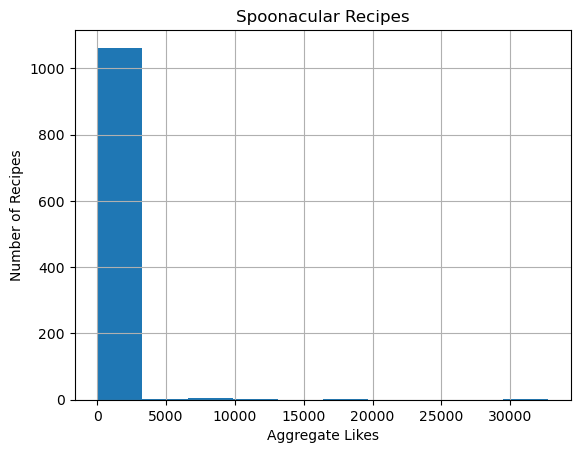

In [97]:
# Create a histogram of the Likes column
simplified_df['Likes'].hist(bins=10)
plt.title("Spoonacular Recipes")
plt.xlabel("Aggregate Likes")
plt.ylabel("Number of Recipes")
plt.show()

In [98]:
# Identify recipes with '0' likes
zero_likes = simplified_df.loc[simplified_df['Likes'] == 0].copy()
print(f'zero_likes: {zero_likes.shape}')

zero_likes: (15, 27)


### Separate Likes outliers from the dataset

Number of outliers: 153


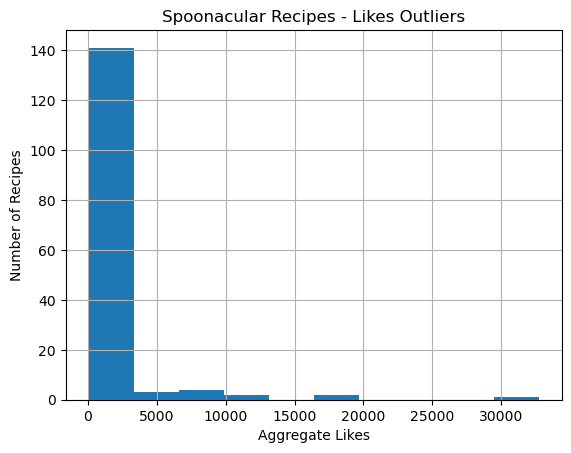

In [99]:
# Get the upper bounds for Likes
upper_likes = calc_stats.loc['upper_bounds', 'Likes']
likes_outliers = simplified_df.loc[simplified_df['Likes'] > upper_likes].copy()

# Display the count of outlier recipes
print(f"Number of outliers: {likes_outliers['Likes'].count()}")

# Create a histogram to understand distribution
likes_outliers['Likes'].hist(bins=10)
plt.title("Spoonacular Recipes - Likes Outliers")
plt.xlabel("Aggregate Likes")
plt.ylabel("Number of Recipes")
plt.show()

In [100]:
# Get the descriptive statistics for the outliers
outlier_stats = likes_outliers['Likes'].describe()
outlier_stats = add_iqr(outlier_stats)
print(outlier_stats)

# Get the DataFrame for outliers of outliers
outliers_squared = likes_outliers.loc[likes_outliers['Likes'] > outlier_stats['upper_bounds']]
print(f'outliers_squared: {outliers_squared.shape}')
outliers_squared.head()

count             153.000000
mean             1164.947712
std              3728.343608
min                43.000000
25%                61.000000
50%               122.000000
75%               396.000000
max             32767.000000
iqr               335.000000
lower_bounds     -441.500000
upper_bounds      898.500000
dtype: float64
outliers_squared: (26, 27)


,ID,Name,Likes,Meal Type,Cuisines,N_ingredients,WW Smart Points,Calories (Amount),Calories (Unit),Calories (% of Daily Needs),...,Sodium (Unit),Sodium (% of Daily Needs),Protein (Amount),Protein (Unit),Protein (% of Daily Needs),Carbohydrates,Cooking Minutes,Carbs (Amount),Carbs (Unit),Carbs (% of Daily Needs)
4,715562,Loaded Baked Potato Soup,5743,"['lunch', 'soup', 'main course', 'main dish', ...",[],9,24.0,623.73,kcal,31.19,...,mg,26.09,21.16,g,42.32,58g,35.0,58.00,g,19.33
74,775585,"Crockpot ""Refried"" Beans",13090,"['antipasti', 'starter', 'snack', 'appetizer',...",[],7,2.0,89.06,kcal,4.45,...,mg,19.35,5.40,g,10.79,16g,35.0,16.00,g,5.33
138,715424,The Best Chili,32767,"['lunch', 'soup', 'main course', 'main dish', ...",['American'],16,6.0,482.48,kcal,24.12,...,mg,30.93,57.75,g,115.49,35g,35.0,35.00,g,11.67
177,715455,Homemade Pecan Pie,7730,['dessert'],['Southern'],6,21.0,445.24,kcal,22.26,...,mg,7.90,4.90,g,9.80,66g,35.0,66.00,g,22.00
208,716431,Crockpot Applesauce,1703,"['antipasti', 'starter', 'snack', 'appetizer',...",[],5,1.0,412.45,kcal,20.62,...,mg,0.36,1.49,g,8.28,NaN,35.0,106.55,g,35.52


The r-value is: 0.5937404101848828


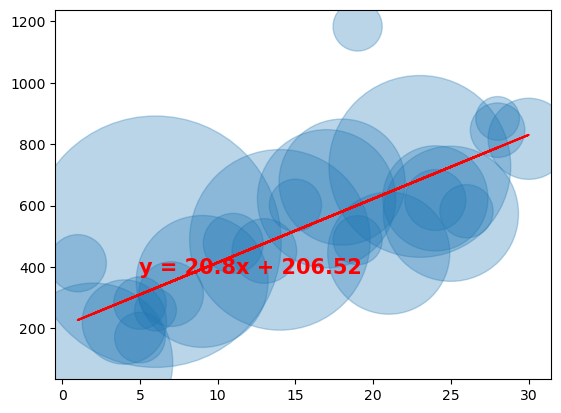

In [101]:
# Plot the relationship between outliers of outliers' WW Smart Points vs Likes
x_values = outliers_squared['WW Smart Points']
y_values = outliers_squared['Calories (Amount)']

fig, ax = plt.subplots()
ax.scatter(x_values, y_values, s=outliers_squared['Likes'], alpha=0.3)
linreg_plot(ax, x_values, y_values, 100, 100)
plt.show()

Number of recipes within limits: 921


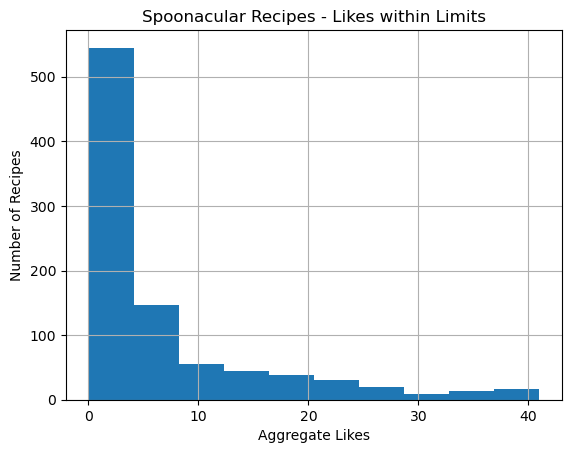

In [102]:
# Get Likes within the limits
likes_within = simplified_df.loc[simplified_df['Likes'] < upper_likes]

# Print the count of recipes within limits
print(f"Number of recipes within limits: {likes_within['Likes'].count()}")

# Create a histogram to understand distribution
likes_within['Likes'].hist(bins=10)
plt.title("Spoonacular Recipes - Likes within Limits")
plt.xlabel("Aggregate Likes")
plt.ylabel("Number of Recipes")
plt.show()

## Convert Spoonacular columns to Food.com equivalents

In [103]:
# Food.com columns
clean_recipes.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients', 'rating', 'meal_type', 'cuisine', 'Calories',
       'Total Fat (PDV)', 'Sugar (PDV)', 'Sodium (PDV)', 'Protein (PDV)',
       'Saturated Fat (PDV)', 'Carbohydrates (PDV)', 'total_fat_g', 'sugar_g',
       'sodium_g', 'protein_g', 'sat_fat_g', 'carbs_g', 'wws_points'],
      dtype='object')

In [104]:
# Current Spoonacular data columns
simplified_df.columns

Index(['ID', 'Name', 'Likes', 'Meal Type', 'Cuisines', 'N_ingredients',
       'WW Smart Points', 'Calories (Amount)', 'Calories (Unit)',
       'Calories (% of Daily Needs)', 'Saturated Fat (Amount)',
       'Saturated Fat (Unit)', 'Saturated Fat (% of Daily Needs)',
       'Sugar (Amount)', 'Sugar (Unit)', 'Sugar (% of Daily Needs)',
       'Sodium (Amount)', 'Sodium (Unit)', 'Sodium (% of Daily Needs)',
       'Protein (Amount)', 'Protein (Unit)', 'Protein (% of Daily Needs)',
       'Carbohydrates', 'Cooking Minutes', 'Carbs (Amount)', 'Carbs (Unit)',
       'Carbs (% of Daily Needs)'],
      dtype='object')

### Convert Aggregate Likes to 5-point Star Rating

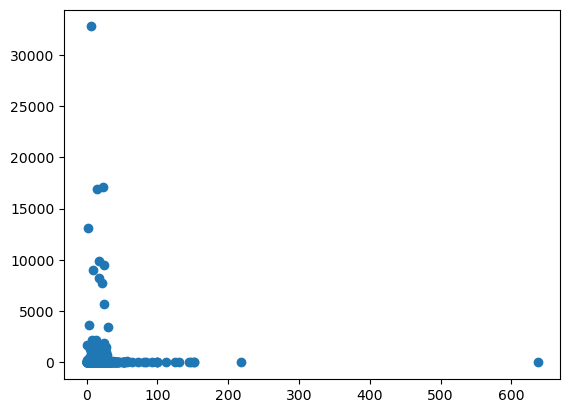

In [105]:
x_values = simplified_df['WW Smart Points']
y_values = simplified_df['Likes']

fig, ax = plt.subplots()
ax.scatter(x_values, y_values)

# CUTOFF

In [106]:
import numpy as np
points_bins = np.arange(-50, 105, 10)
bins_df = pd.cut(clean_recipes['wws_points'], bins=points_bins)
points_df = clean_recipes.set_index(bins_df)
points_df.index.name = "WWS Point Ranges"
points_df

binned_df = points_df.groupby(['WWS Point Ranges']).mean(numeric_only=True)
binned_df

,id,minutes,contributor_id,n_steps,n_ingredients,rating,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
WWS Point Ranges,,,,,,,,,,,,,,,,,,,,
"(-50, -40]",155278.333333,26.000000,1.777783e+05,7.333333,7.000000,4.793651,307.500000,7.333333,5.333333,8.000000,114.000000,7.666667,1.666667,4.766667,2.666667,0.192000,57.000000,1.533333,5.000000,-42.666667
"(-40, -30]",241638.826087,36.739130,2.657162e+05,8.304348,9.434783,4.449103,437.460870,26.782609,5.217391,27.478261,105.260870,27.521739,4.173913,17.408696,2.608696,0.659478,52.630435,5.504348,12.521739,-33.608696
"(-30, -20]",186026.623853,40.954128,2.219422e+05,9.587156,9.330275,4.581783,407.315596,29.853211,6.541284,22.614679,84.403670,31.908257,3.431193,19.404587,3.270642,0.542752,42.201835,6.381651,10.293578,-23.266055
"(-20, -10]",194924.659164,43.289389,2.438412e+05,11.151125,10.501608,4.632646,408.744695,32.675241,9.967846,25.276527,70.102894,37.035370,5.003215,21.238907,4.983923,0.606637,35.051447,7.407074,15.009646,-13.868167
"(-10, 0]",220093.447598,39.115721,2.231102e+06,10.484716,10.030568,4.629382,336.088319,27.009825,10.086245,23.441048,43.806769,32.441048,6.516376,17.556386,5.043122,0.562585,21.903384,6.488210,19.549127,-3.388646
"(0, 10]",217020.739059,36.586433,1.253451e+06,10.021335,9.564004,4.607494,262.837199,20.935996,10.890591,17.686543,22.163567,25.511488,7.195295,13.608397,5.445295,0.424477,11.081783,5.102298,21.585886,5.102845
"(10, 20]",207590.878335,40.062967,6.236330e+06,10.769477,10.572038,4.633873,317.119317,26.487727,23.510139,19.362860,21.356457,29.354322,9.367129,17.217022,11.755069,0.464709,10.678228,5.870864,28.101387,14.923159
"(20, 30]",214695.879699,39.095238,2.490799e+05,10.097744,10.478697,4.620763,315.258396,24.922306,39.210526,17.368421,19.977444,26.824561,10.040100,16.199499,19.605263,0.416842,9.988722,5.364912,30.120301,24.839599
"(30, 40]",219948.319820,37.207207,2.143720e+05,10.738739,9.797297,4.631624,329.491441,24.198198,54.918919,14.851351,19.495495,27.972973,11.626126,15.728829,27.459459,0.356432,9.747748,5.594595,34.878378,35.018018


The r-value is: 0.1791805250457192


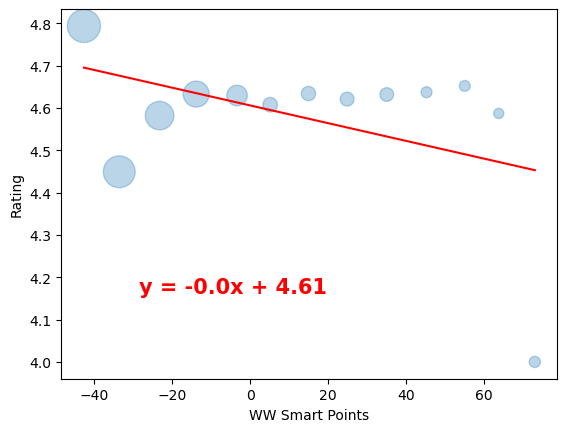

In [107]:
x_val = binned_df['wws_points']
y_val = binned_df['rating']
fig, ax = plt.subplots()
ax.scatter(x_val, y_val, s=binned_df['protein_g']*10, alpha=0.3)
ax.set_xlabel("WW Smart Points")
ax.set_ylabel("Rating")
# ax.plot(x_val, y_val)
linreg_plot(ax, x_val, y_val, 100, 100)

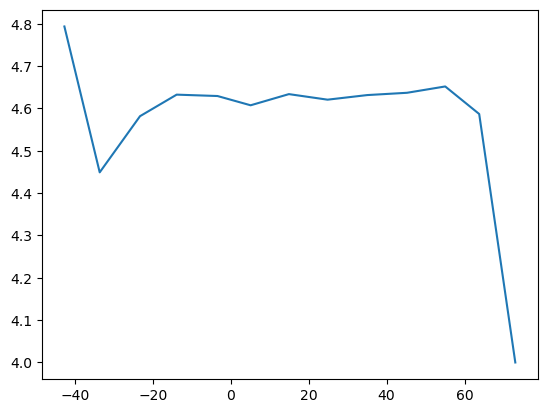

In [108]:
plt.plot(x_val, y_val)

In [109]:
binned_df['wws_points'].describe()

count    13.000000
mean     15.389396
std      37.828314
min     -42.666667
25%     -13.868167
50%      14.923159
75%      45.217391
max      73.000000
Name: wws_points, dtype: float64

In [110]:
# Check recipes <40 wws_points
low_points = clean_recipes.loc[clean_recipes['wws_points'] < -40]
low_points

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,...,Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
78163,egyptian red snapper in red pepper mint sauce,133946,20,183964,2005-08-18,"['30-minutes-or-less', 'time-to-make', 'course...","[328.6, 9.0, 7.0, 5.0, 120.0, 5.0, 1.0]",4,"['saute onion in olive oil until golden', 'add...",this recipe is posted for the zaar world tour ...,...,120.0,5.0,1.0,5.85,3.5,0.120,60.0,1.0,3.0,-44
88176,garlic chicken kabobs on rosemary skewers,175916,40,274719,2006-07-03,"['lactose', '60-minutes-or-less', 'time-to-mak...","[283.5, 4.0, 0.0, 6.0, 108.0, 3.0, 3.0]",11,['to roast garlic: fill an oven-safe dish half...,garlic chicken kabobs on rosemary skewers from...,...,108.0,3.0,3.0,2.60,0.0,0.144,54.0,0.6,9.0,-44


15
The r-value is: 0.09326699095996178


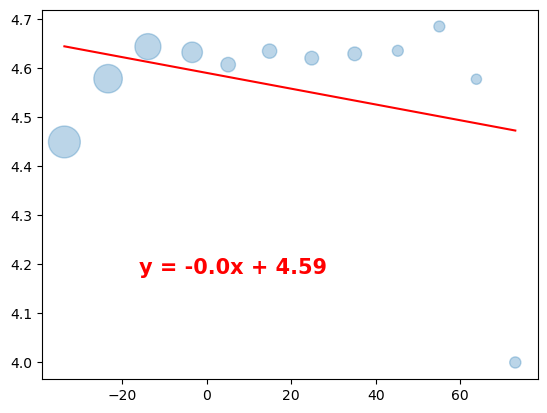

,id,minutes,contributor_id,n_steps,n_ingredients,rating,Calories,Total Fat (PDV),Sugar (PDV),Sodium (PDV),Protein (PDV),Saturated Fat (PDV),Carbohydrates (PDV),total_fat_g,sugar_g,sodium_g,protein_g,sat_fat_g,carbs_g,wws_points
count,135.000000,135.000000,1.350000e+02,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000,135.000000
mean,258126.896296,52.355556,3.566886e+05,12.177778,10.733333,4.587592,336.205185,25.637037,17.377778,21.177778,33.074074,30.000000,9.229630,16.664074,8.688889,0.508267,16.537037,6.000000,27.688889,6.148148
std,138020.388441,31.282647,3.988600e+05,6.847885,4.510684,0.598429,215.409442,21.170808,17.275151,17.104537,27.755766,28.449222,7.885317,13.761025,8.637576,0.410509,13.877883,5.689844,23.655950,13.321803
min,11716.000000,5.000000,1.533000e+03,3.000000,2.000000,1.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-22.000000
25%,150435.000000,27.000000,1.364850e+05,7.500000,8.000000,4.387500,177.850000,7.500000,5.000000,6.500000,11.000000,6.500000,3.000000,4.875000,2.500000,0.156000,5.500000,1.300000,9.000000,0.000000
50%,260763.000000,50.000000,2.427290e+05,11.000000,10.000000,4.800000,324.200000,24.000000,12.000000,18.000000,24.000000,24.000000,7.000000,15.600000,6.000000,0.432000,12.000000,4.800000,21.000000,4.000000
75%,369987.000000,72.500000,4.645680e+05,16.000000,13.000000,5.000000,471.450000,36.000000,25.000000,32.000000,50.000000,44.000000,14.000000,23.400000,12.500000,0.768000,25.000000,8.800000,42.000000,10.000000
max,513472.000000,130.000000,2.324285e+06,41.000000,23.000000,5.000000,956.700000,86.000000,95.000000,74.000000,116.000000,120.000000,33.000000,55.900000,47.500000,1.776000,58.000000,24.000000,99.000000,61.000000


In [111]:
no_oamc = parse_tags(['oamc-freezer-make-ahead'], 'tags', clean_recipes, 'id')
test_df = clean_recipes.loc[~clean_recipes['id'].isin(no_oamc['oamc-freezer-make-ahead']['id_list'])]
test_df

points_bins = np.arange(-40, 105, 10)
print(len(points_bins))
bins_df = pd.cut(test_df['wws_points'], bins=points_bins)
points_df = test_df.set_index(bins_df)
points_df.index.name = "WWS Point Ranges"
points_df

binned_df = points_df.groupby(['WWS Point Ranges']).mean(numeric_only=True)
binned_df

x_val = binned_df['wws_points']
y_val = binned_df['rating']
fig, ax = plt.subplots()
ax.scatter(x_val, y_val, s=binned_df['protein_g']*10, alpha=0.3)
# ax.plot(x_val, y_val)
linreg_plot(ax, x_val, y_val, 100, 100)

test1_df = clean_recipes.loc[clean_recipes['id'].isin(no_oamc['oamc-freezer-make-ahead']['id_list'])]
test1_df.describe()

ShapiroResult(statistic=0.9392381310462952, pvalue=2.0298075286556694e-13)

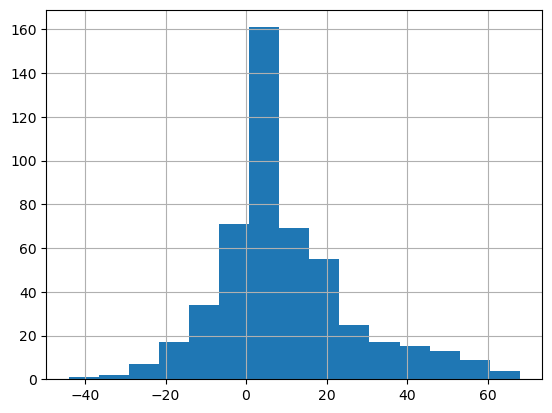

In [112]:
# STATISTICAL TESTING and PLOTS
sample_set = clean_recipes['wws_points'].sample(n=500)
sample_set.hist(bins=15)

stats.shapiro(sample_set)

In [113]:
result = stats.anderson(clean_recipes['wws_points'])

print('Statistic: %.3f' % result.statistic)
p = 0
# interpret results
for i in range(len(result.critical_values)):
    slevel, cvalues = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (slevel, cvalues))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (slevel, cvalues))

Statistic: 92.896
15.000: 0.576, data does not look normal (reject H0)
10.000: 0.655, data does not look normal (reject H0)
5.000: 0.786, data does not look normal (reject H0)
2.500: 0.917, data does not look normal (reject H0)
1.000: 1.091, data does not look normal (reject H0)


In [114]:
# Parse the ingredients column
# Identify how to isolate each tag
tag_string = clean_recipes['ingredients'][1].strip("[]")
tag_string = tag_string.split(', ')
tag_string[62].strip("'")

# Get a list of unique tags
unique_ingredients = []
for string in clean_recipes['ingredients']:
    # Strip and split the string to a list
    tag_list = string.strip("[]").split(', ')
    for word_idx in range(len(tag_list)):
        # Get the tag
        tag = tag_list[word_idx].strip("'")
        if tag not in unique_ingredients:
            unique_ingredients.append(tag)

# Display the tags alphabetically
print(f"Number of unique ingredients: {len(unique_ingredients)}")

sorted_ingredients = sorted(unique_ingredients)
sorted_ingredients

for row in range(0, 52):
    sorted_ingredients[row] = sorted_ingredients[row].strip('"')
sorted_ingredients

# open file
with open('ingredients_commas.txt', 'w+') as f:
     
    # write elements of list
    for items in sorted_ingredients:
        f.write('%s, ' %items)
    print("File written successfully")
 
 
# close the file
f.close()
# # for line in sorted_ingredients[0:52]:
# #     print(line.strip('"'))
# sorted = [line.strip('"') for line in unique_ingredients[0:52]]
# unique_ingredients[0:52]

KeyError: 1

In [ ]:
import food
report = food.get_report()
report[32]['Description']

In [ ]:
categories = []
for row in range(len(report)):
    categories.append(report[row]['Category'])

new_data = set(categories)
old_data = set(sorted_ingredients)

# if (new_data & old_data):
#     print(new_data & old_data)
if len(new_data.intersection(old_data)) > 0:
    print(new_data.intersection(old_data))
else:
    print("no common elements")
new_data = set([word.lower() for word in list(new_data)])
old_data = set([word.lower() for word in list(old_data)])

if len(new_data.intersection(old_data)) > 0:
    intersect = new_data.intersection(old_data)
    print(len(intersect))
    print(intersect)
else:
    print("no common elements")

# Return dataframe with these common ingredients


In [ ]:
# Recipes with negative points are high in protein
negative_points = clean_recipes.loc[clean_recipes['wws_points'] < 0].copy()
print(f'negative_points: {negative_points.shape}')
negative_points.head()

In [ ]:
x_values = negative_points['wws_points']
y_values = negative_points['protein_g']

fig, ax = plt.subplots()
ax.scatter(x_values, y_values)
linreg_plot(ax, x_values, y_values, 80, 80)

In [ ]:
x_values = negative_points['total_fat_g']
y_values = negative_points['protein_g']

fig, ax = plt.subplots()
ax.scatter(x_values, y_values)
linreg_plot(ax, x_values, y_values, 80, 80)

In [ ]:
x_values = negative_points['Calories']
y_values = negative_points['protein_g']

fig, ax = plt.subplots()
ax.scatter(x_values, y_values)
linreg_plot(ax, x_values, y_values, 80, 80)

In [ ]:
x_values = negative_points['wws_points']
y_values = negative_points['carbs_g']

fig, ax = plt.subplots()
ax.scatter(x_values, y_values)
linreg_plot(ax, x_values, y_values, 80, 80)

In [ ]:
x_values = negative_points['Calories']
y_values = negative_points['carbs_g']

fig, ax = plt.subplots()
ax.scatter(x_values, y_values)
linreg_plot(ax, x_values, y_values, 80, 80)

In [ ]:
recipe_sample = clean_recipes.sample(n=500)
x_values = recipe_sample['wws_points']
y_values = recipe_sample['rating']

fig_test, ax_test = plt.subplots()
ax_test.scatter(x_values, y_values)
linreg_plot(ax_test, x_values, y_values, 80, 80)

In [ ]:
# CREATE A BUBBLE PLOT? Bin the WW Smart Points, use the count of each bin as the bubble size (and plot this as the 3rd dimension)

##